# NGC 309: Spatial matching of the post-processed imaging data cube with the IFS data (Part1: Before spec-photo rescaling)
### The IFS data for this galaxy is taken from the CALIFA survey

In [1]:
import numpy as np
import math
from astropy.io import fits
import os
import sys
import matplotlib.pyplot as plt
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)
from matplotlib.ticker import ScalarFormatter

global PIXEDFIT_HOME
PIXEDFIT_HOME = os.environ['PIXEDFIT_HOME']
sys.path.insert(0, PIXEDFIT_HOME+'/src')

### Call function specphoto_CALIFAGALEXSDSS2MASSVISTAWISE within piXedfit_spectrophotometric 

In [2]:
from piXedfit_spectrophotometric import specphoto_CALIFAGALEXSDSS2MASSVISTAWISE

In [3]:
stamp_image = "stamp_psfmatch_crop_GI1_009100_NGC0309-nd-intbgsub.fits"
## pixel size of the post-processed imaging data cube
pixsize_image = 1.5
photo_fluxmap = "crop_fluxmap_califa_NGC309.fits"
CALIFA_fits_file = "NGC0309.COMB.rscube.fits.gz"
# pixel size of CALIFA (in arcsec)
pixsize_CALIFA = 1.0
out_fits_name = "specphoto_crop_fluxmap_califa_NGC309.fits"

specphoto_CALIFAGALEXSDSS2MASSVISTAWISE(stamp_image=stamp_image, pixsize_image=pixsize_image, 
                                   photo_fluxmap=photo_fluxmap, CALIFA_fits_file=CALIFA_fits_file, 
                                   pixsize_CALIFA=pixsize_CALIFA, out_fits_name=out_fits_name)

[Spectral smooting..]
[End of Spectral smooting..]
Wave id: 1900 from 1901  ==> progress: 100%


'specphoto_crop_fluxmap_califa_NGC309.fits'

### Check the FITS data product

In [5]:
specphoto = fits.open("specphoto_crop_fluxmap_califa_NGC309.fits")
specphoto.info()
print (specphoto[0].header)

Filename: specphoto_crop_fluxmap_califa_NGC309.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      21   ()      
  1  SPEC_REGION    1 ImageHDU         8   (131, 131)   float64   
  2  PHOTO_REGION    1 ImageHDU         8   (131, 131)   float64   
  3  PHOTO_FLUX    1 ImageHDU         9   (131, 131, 12)   float64   
  4  PHOTO_FLUXERR    1 ImageHDU         9   (131, 131, 12)   float64   
  5  WAVE          1 ImageHDU         7   (1901,)   float64   
  6  SPEC_FLUX     1 ImageHDU         9   (131, 131, 1901)   float64   
  7  SPEC_FLUXERR    1 ImageHDU         9   (131, 131, 1901)   float64   
  8  SPEC_GOOD_PIX    1 ImageHDU         9   (131, 131, 1901)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T   

### Check the IFU data coverage (red-colored region)

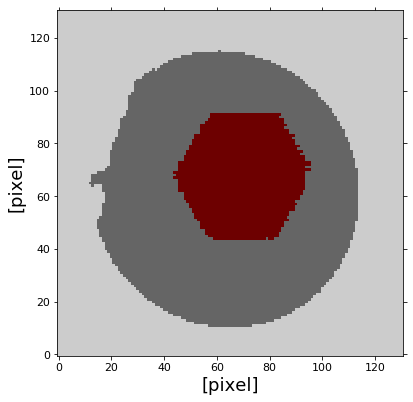

In [6]:
### plot photo and spec+photo regio
fig1 = plt.figure(figsize=(8,6))
f1 = plt.subplot()
plt.setp(f1.get_xticklabels(), fontsize=11)
plt.setp(f1.get_yticklabels(), fontsize=11)
plt.tick_params(axis='y', which='both', right='on')
plt.tick_params(axis='x', which='both', top='on')
plt.xlabel('[pixel]', fontsize=18)
plt.ylabel('[pixel]', fontsize=18)

plt.imshow(specphoto['photo_region'].data*10, origin='lower', 
           cmap='nipy_spectral_r', alpha=1.0, vmin=0, vmax=10)
plt.imshow(specphoto['spec_region'].data*1, origin='lower', 
           cmap='nipy_spectral_r', alpha=0.5, vmin=0, vmax=10)

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9)
plt.savefig("specphoto_cov.png")

### Make gri composite image to show the images+IFS data coverage

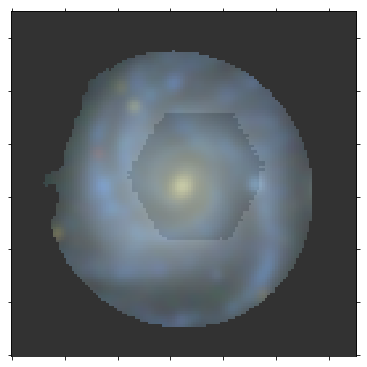

In [7]:
from astropy.visualization import make_lupton_rgb

g = specphoto['PHOTO_FLUX'].data[3]*10
r = specphoto['PHOTO_FLUX'].data[4]*10
i = specphoto['PHOTO_FLUX'].data[5]*10

rgb_default = make_lupton_rgb(i, r, g, filename="ngc6976-default.jpeg")

### plot photo and spec+photo regio
fig1 = plt.figure(figsize=(8,6))
f1 = plt.subplot()
plt.setp(f1.get_xticklabels(), visible=False)
plt.setp(f1.get_yticklabels(), visible=False)
plt.setp(f1.get_xticklabels(), fontsize=11)
plt.setp(f1.get_yticklabels(), fontsize=11)
plt.tick_params(axis='y', which='both', right='on')
plt.tick_params(axis='x', which='both', top='on')
#plt.xlabel('[pixel]', fontsize=18)
#plt.ylabel('[pixel]', fontsize=18)

plt.imshow(rgb_default, origin='lower', alpha=1.0)
plt.imshow(specphoto['spec_region'].data*5, origin='lower', 
           cmap='Greys', alpha=0.2, vmin=0, vmax=10)

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9)
plt.savefig("specphoto_cov_rgb.png")

### Get pixel-wise photometric or spectrophotometric SEDs

In [8]:
### get spec+photo SED: (band,y,x) ==> (y,x,band)
unit = float(specphoto[0].header['unit'])
pix_photo_flux = np.transpose(specphoto['photo_flux'].data, axes=(1,2,0))*unit
pix_photo_flux_err = np.transpose(specphoto['photo_fluxerr'].data, axes=(1,2,0))*unit

pix_spec_flux = np.transpose(specphoto['spec_flux'].data, axes=(1,2,0))*unit
pix_spec_flux_err = np.transpose(specphoto['spec_fluxerr'].data, axes=(1,2,0))*unit

spec_wave = specphoto['wave'].data

### get filters:
nbands = int(specphoto[0].header['nfilters'])
filters = []
for bb in range(0,nbands):
    str_temp = 'fil%d' % bb
    filters.append(specphoto[0].header[str_temp])
print (filters)

from filtering import cwave_filters

photo_wave = cwave_filters(filters)

['galex_fuv', 'galex_nuv', 'sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z', '2mass_j', '2mass_h', '2mass_k', 'wise_w1', 'wise_w2']


### Plot SEDs of 100 pixels within the central 100x100 square

/asiaa/home/abdurrouf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


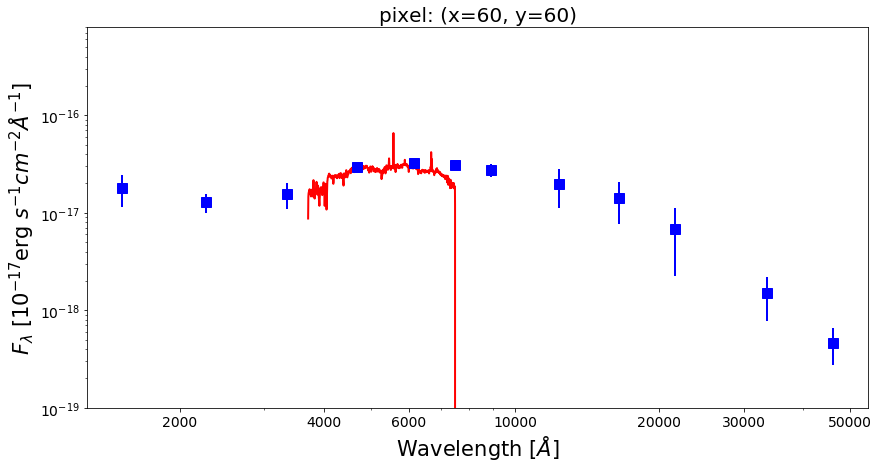

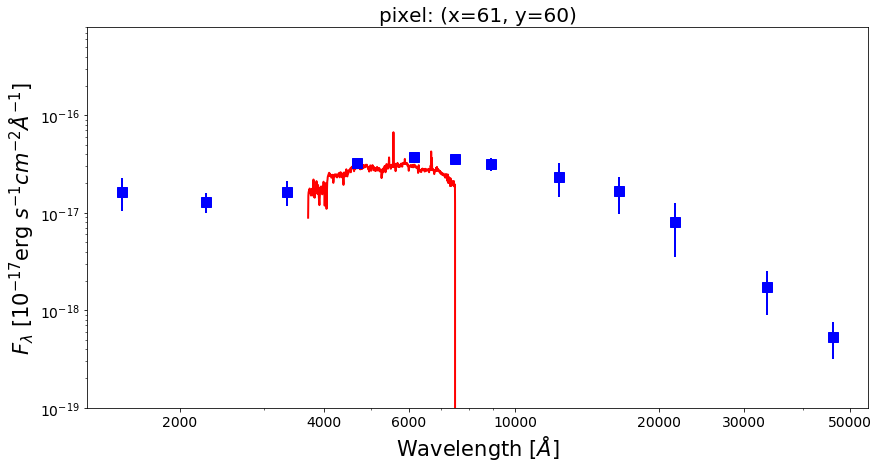

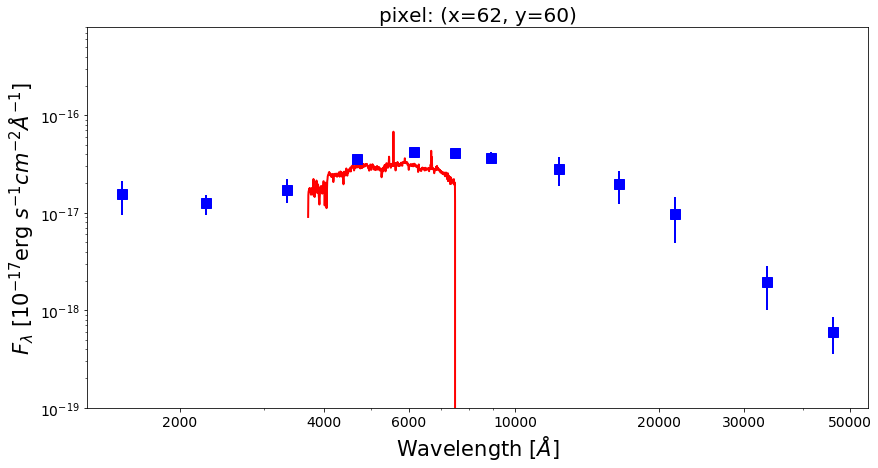

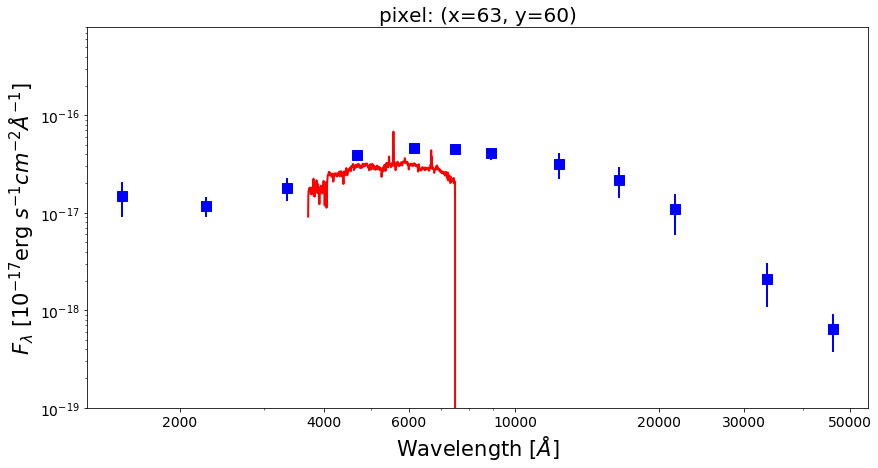

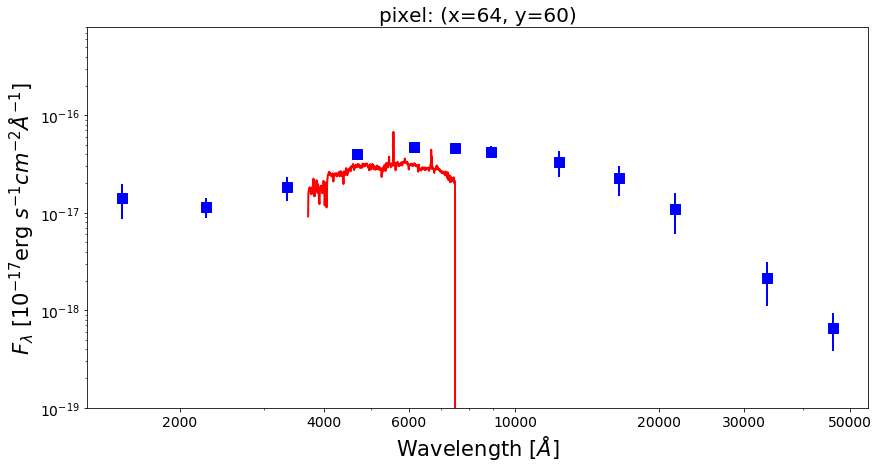

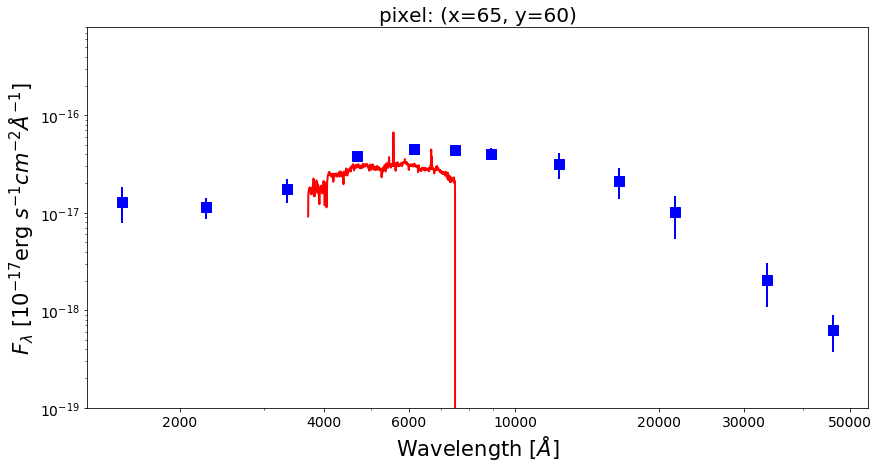

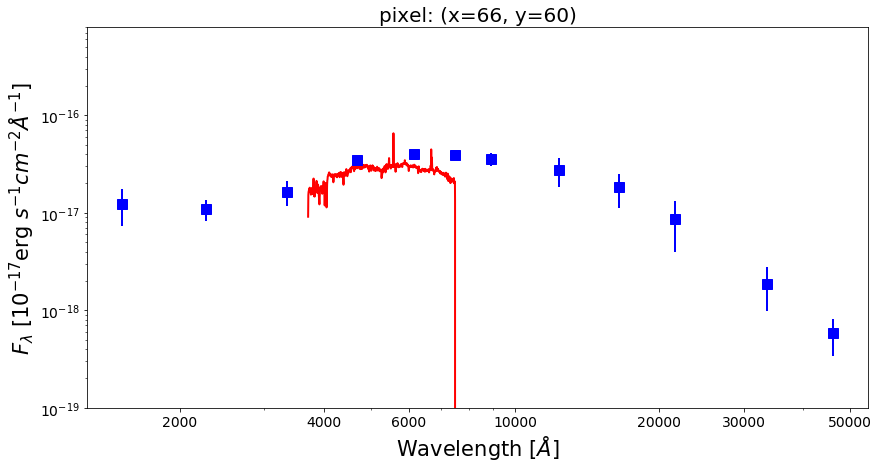

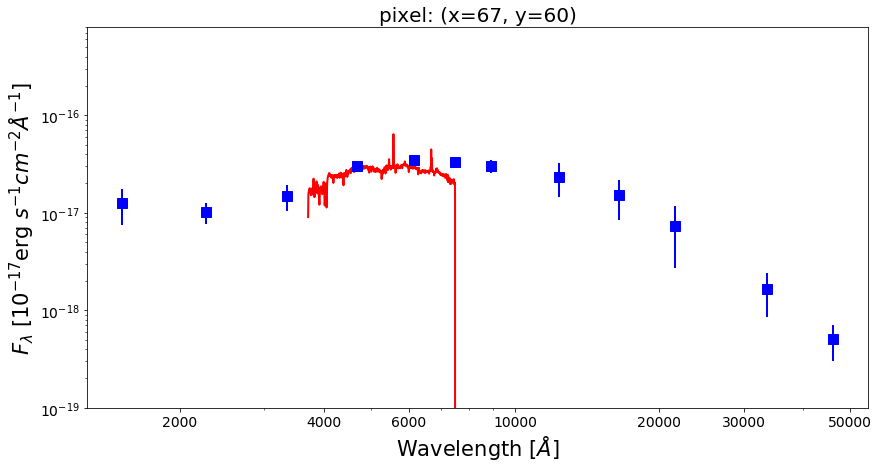

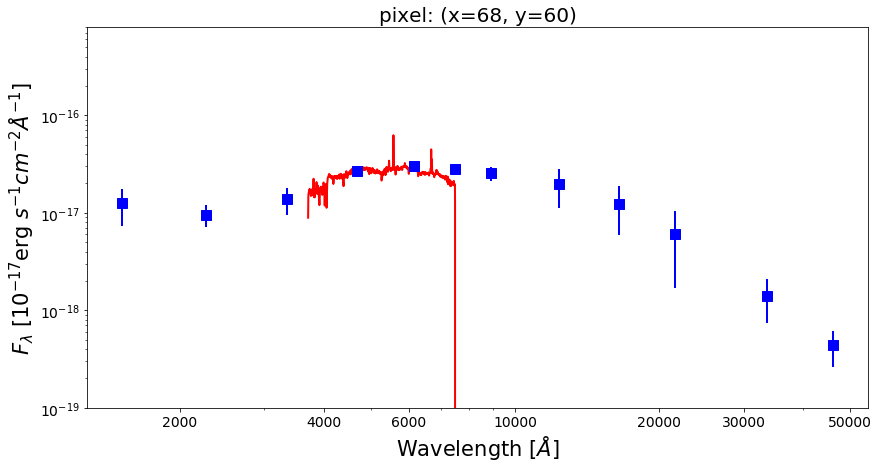

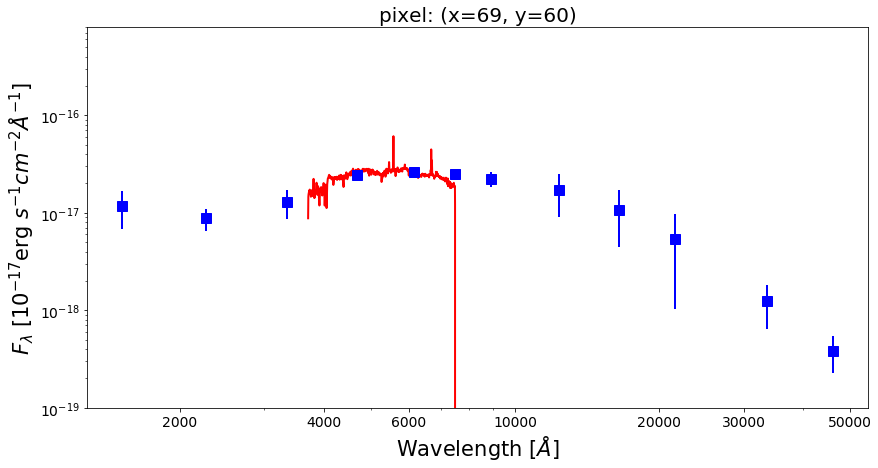

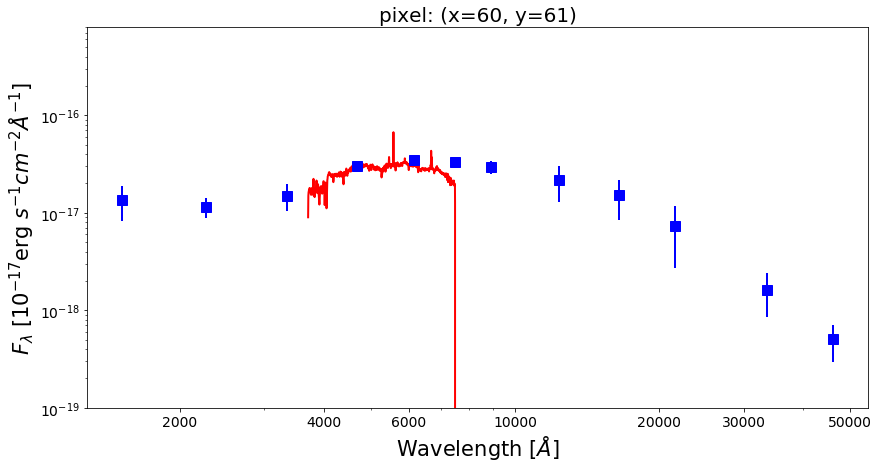

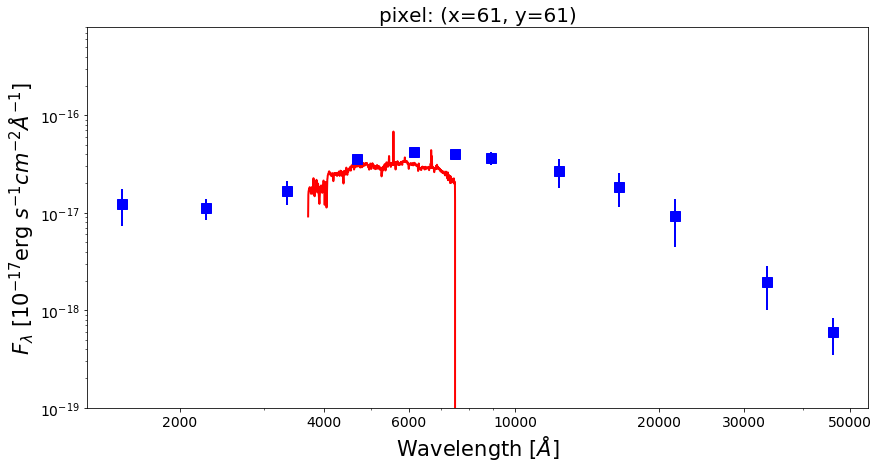

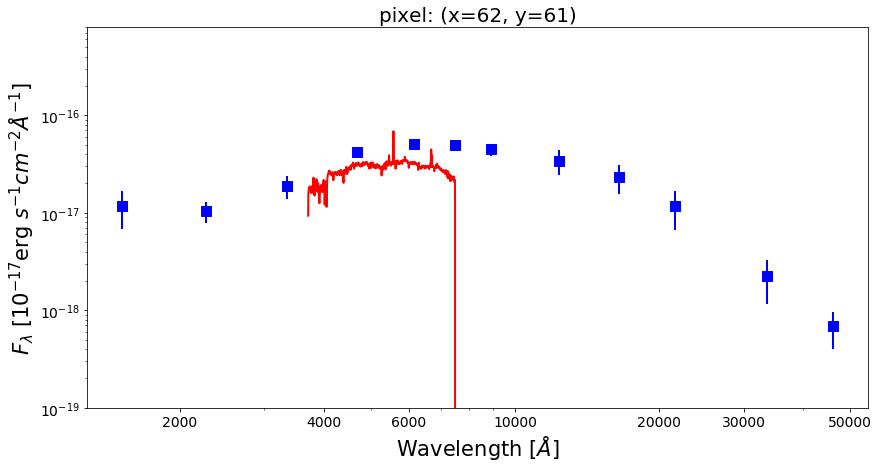

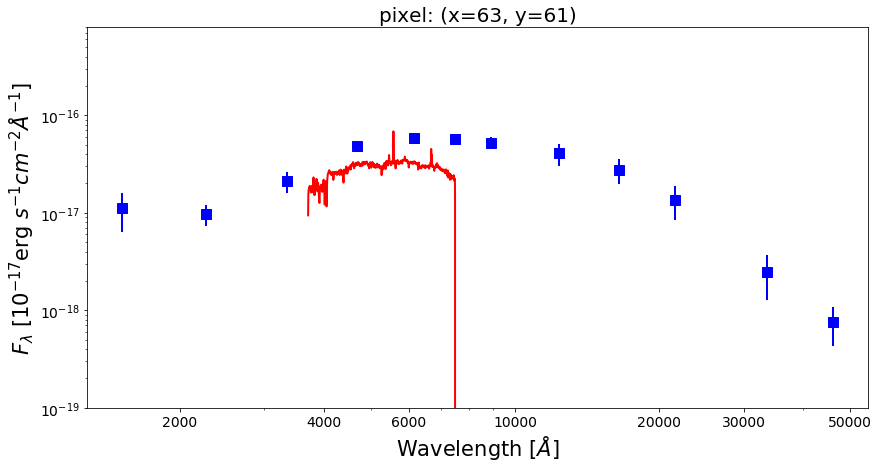

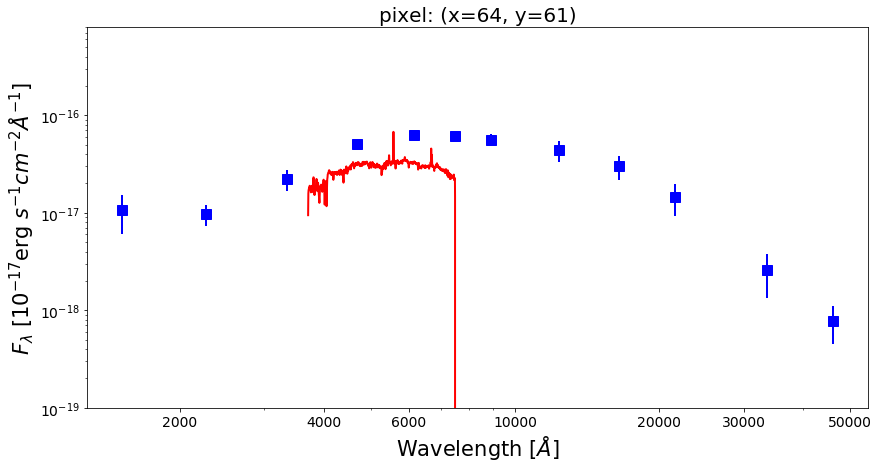

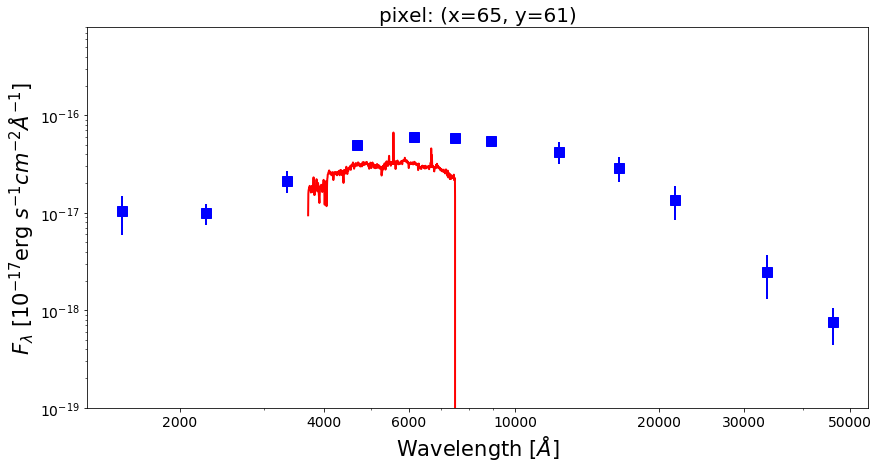

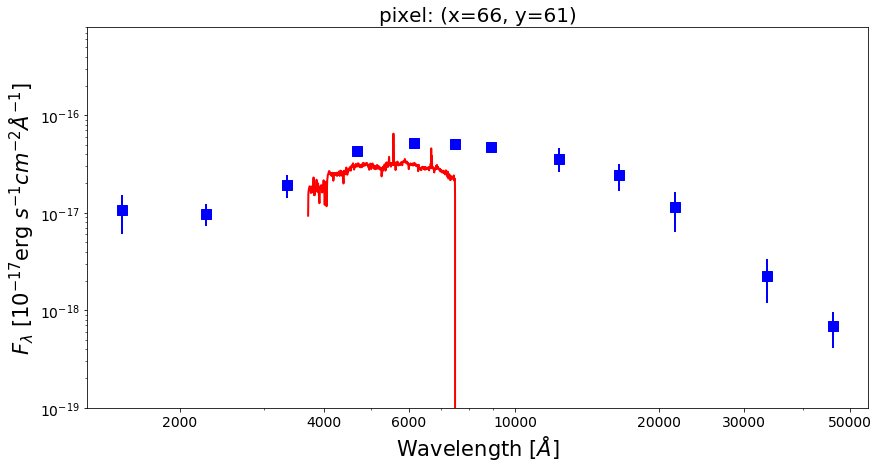

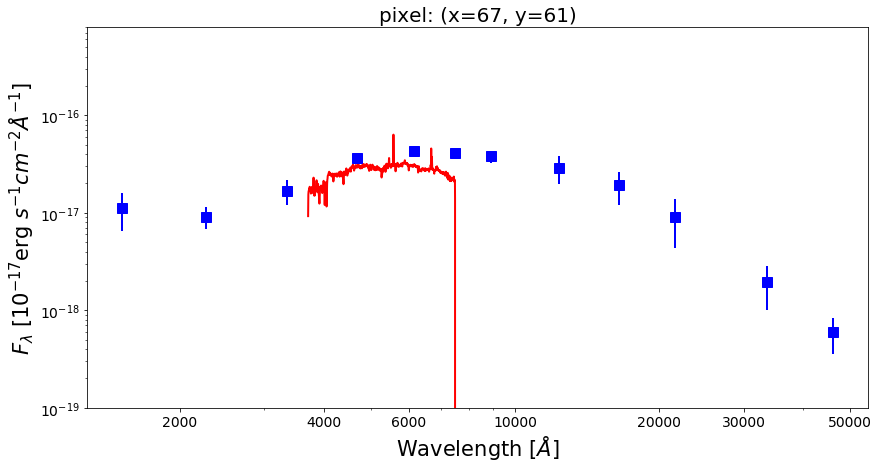

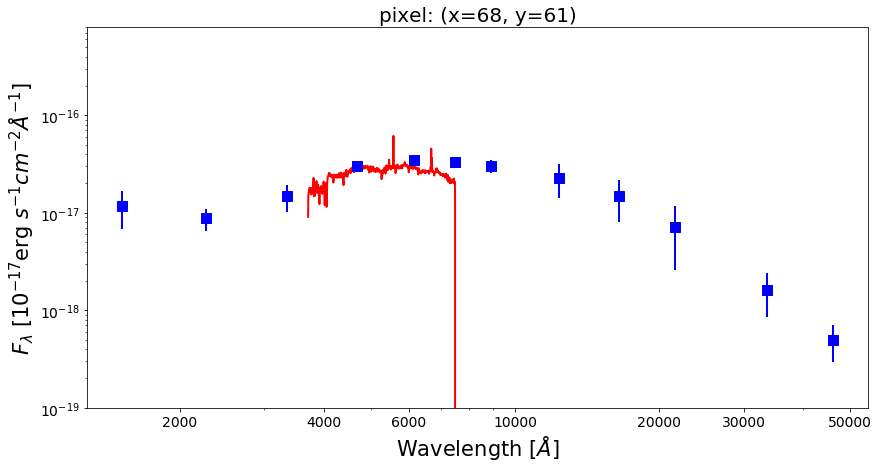

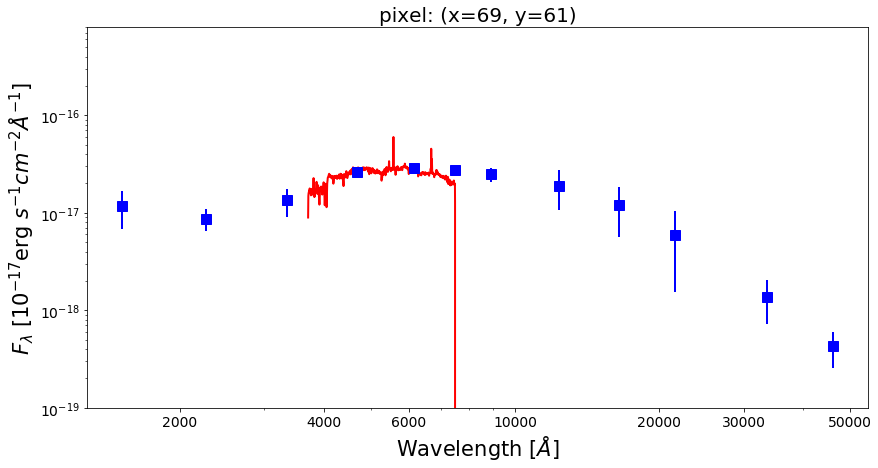

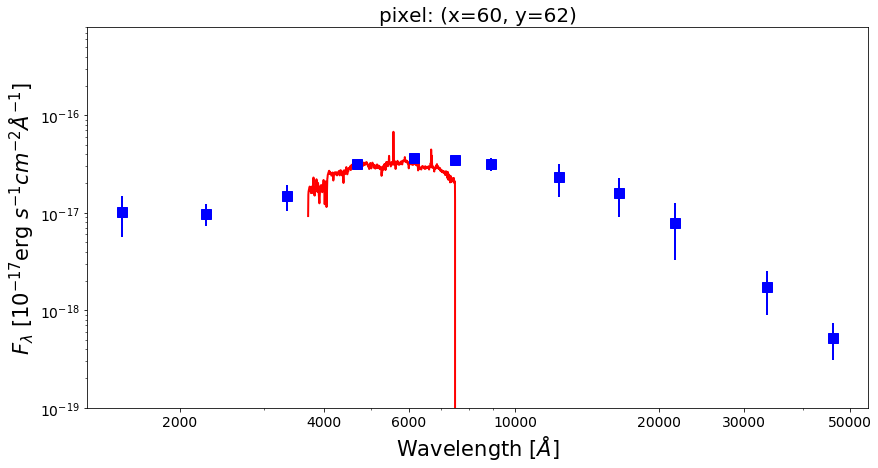

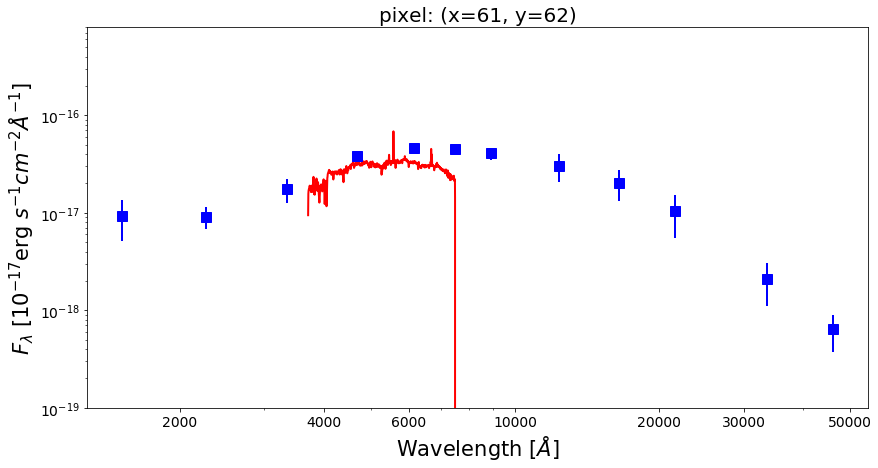

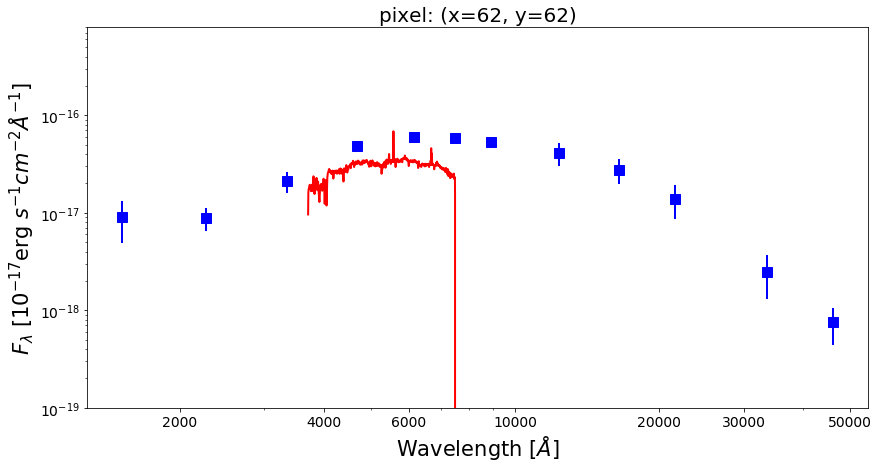

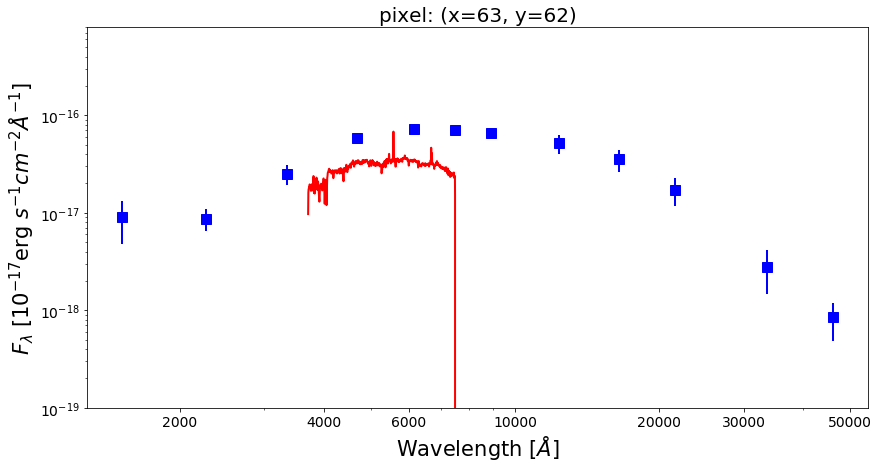

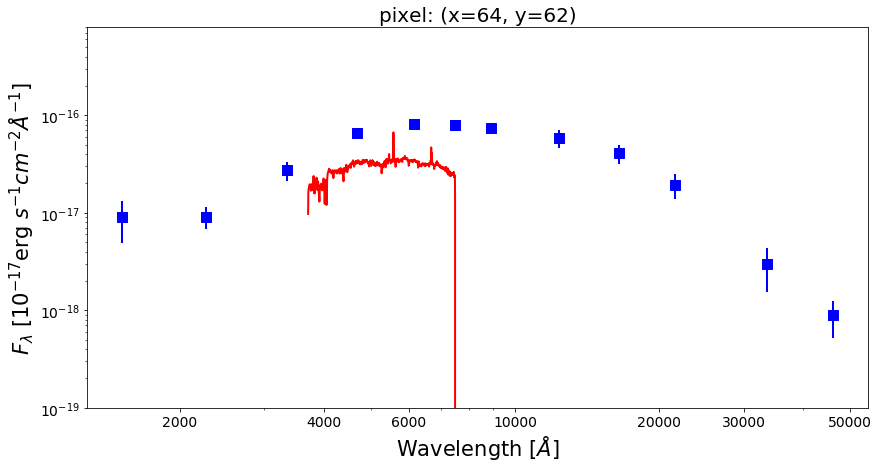

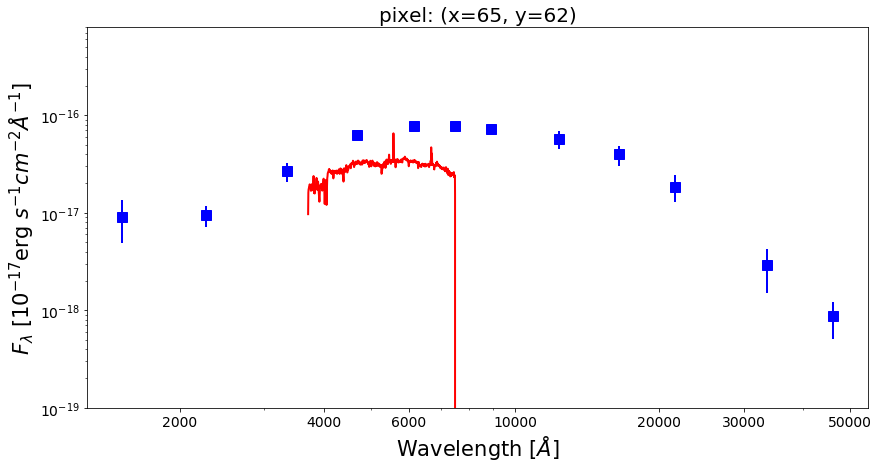

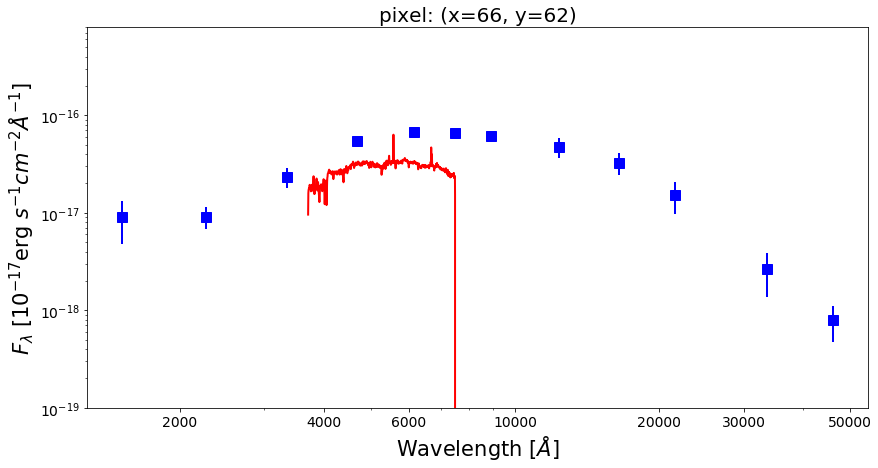

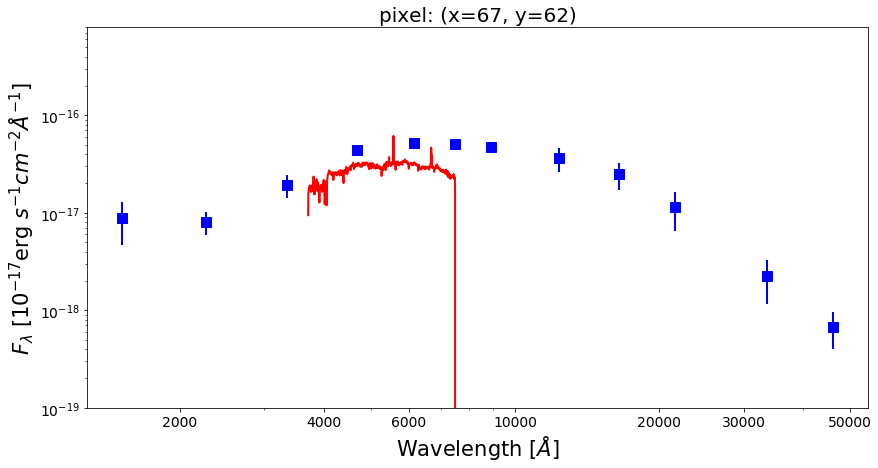

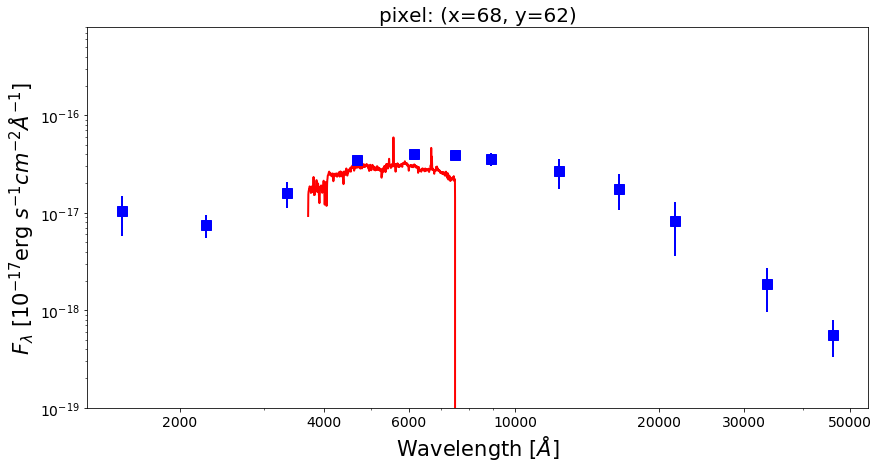

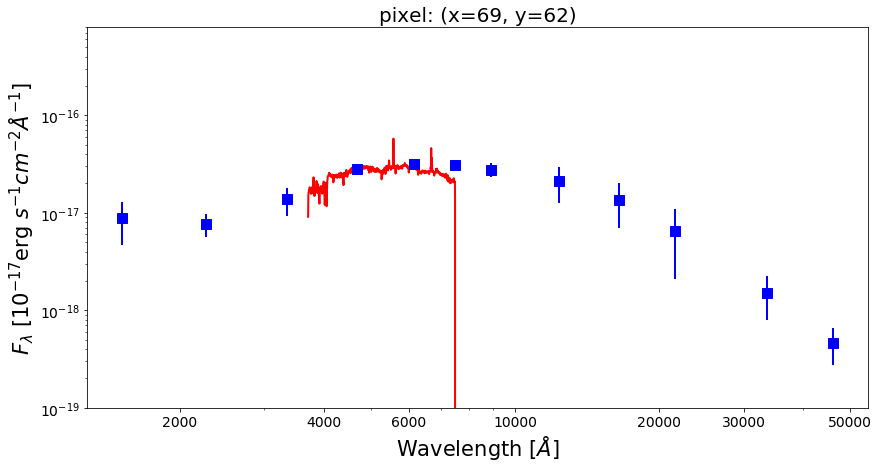

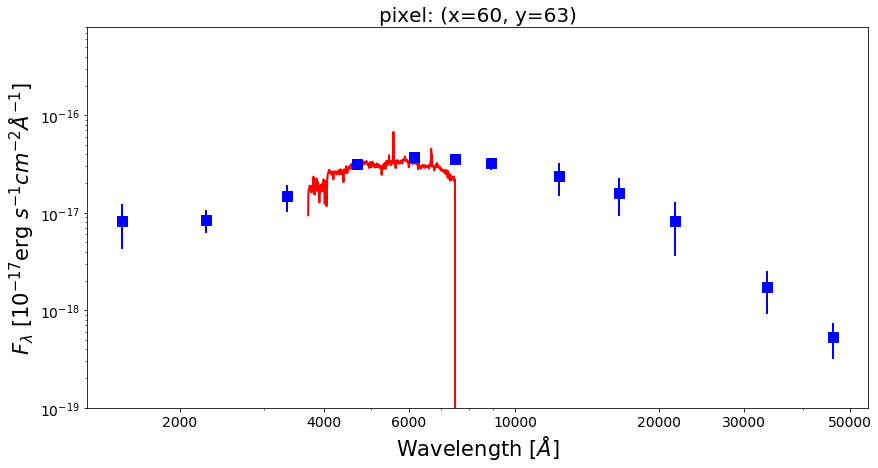

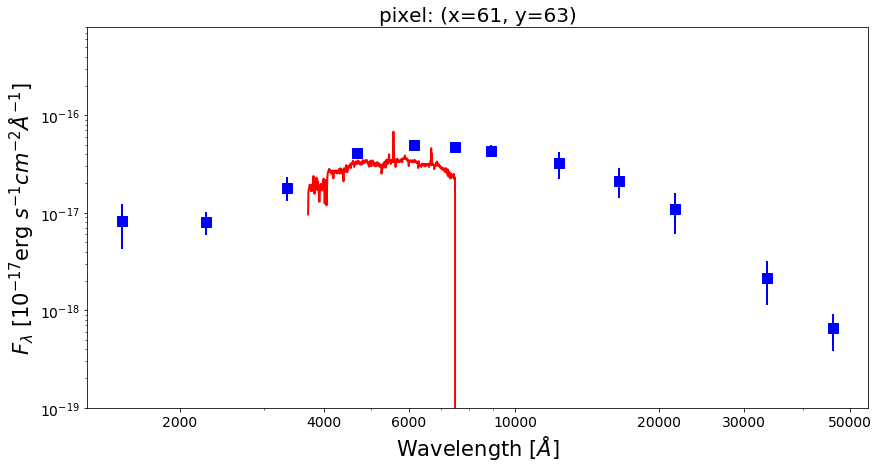

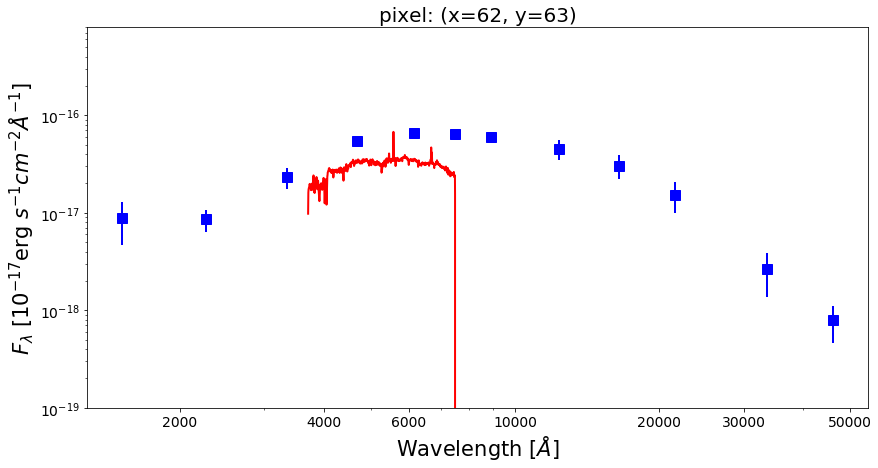

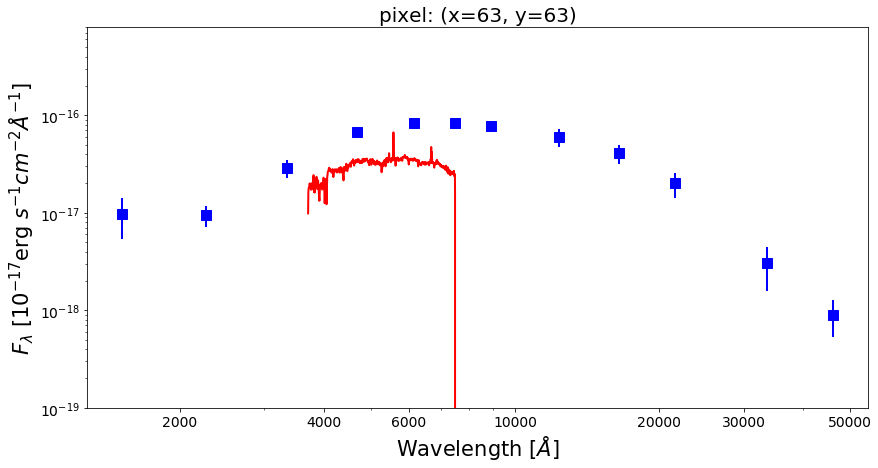

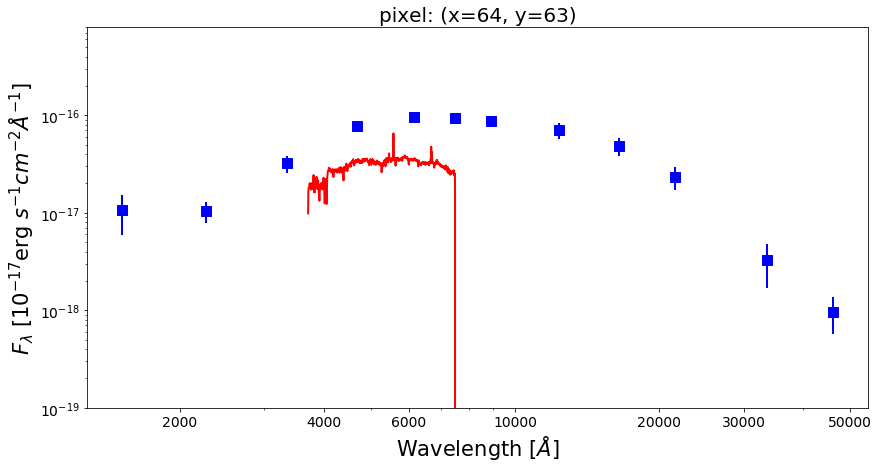

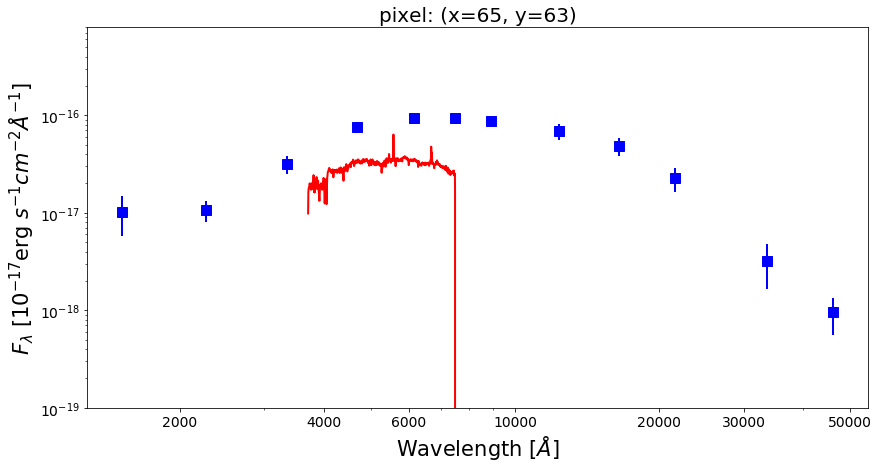

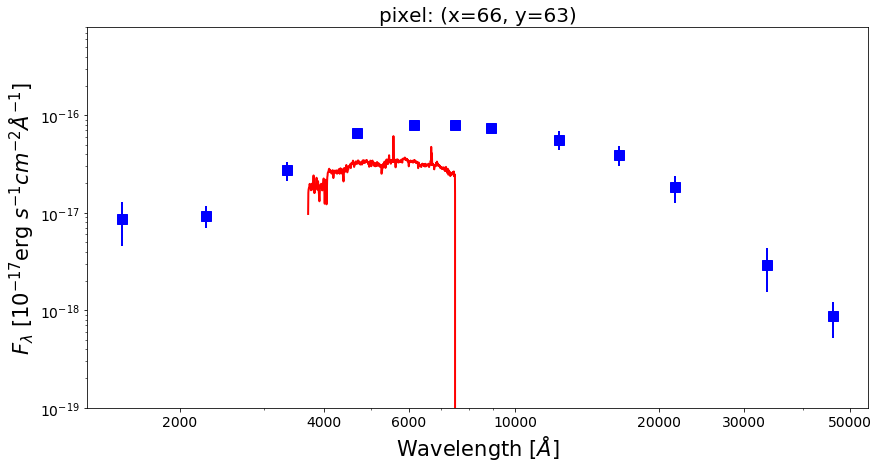

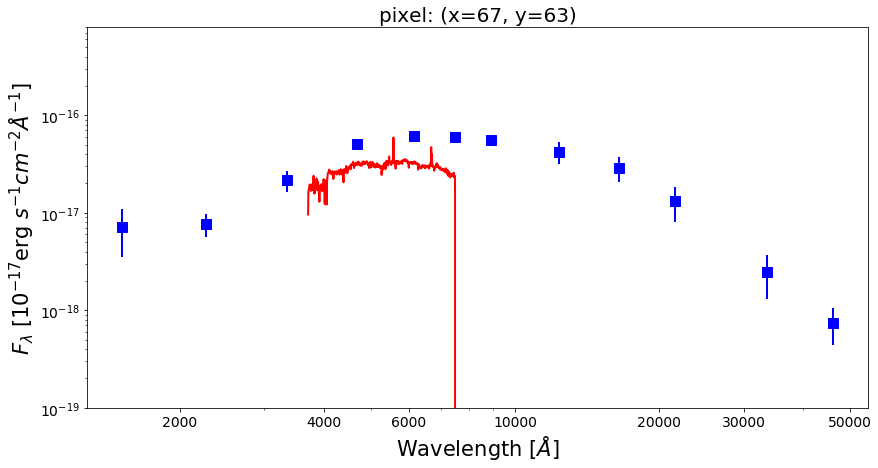

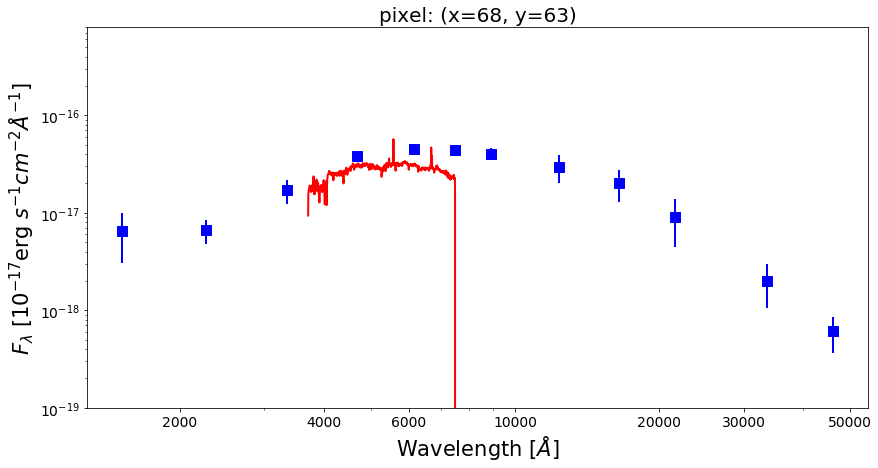

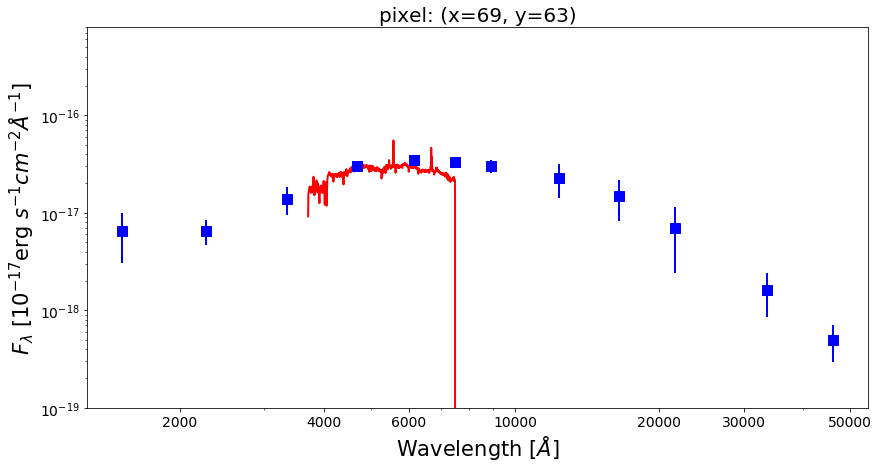

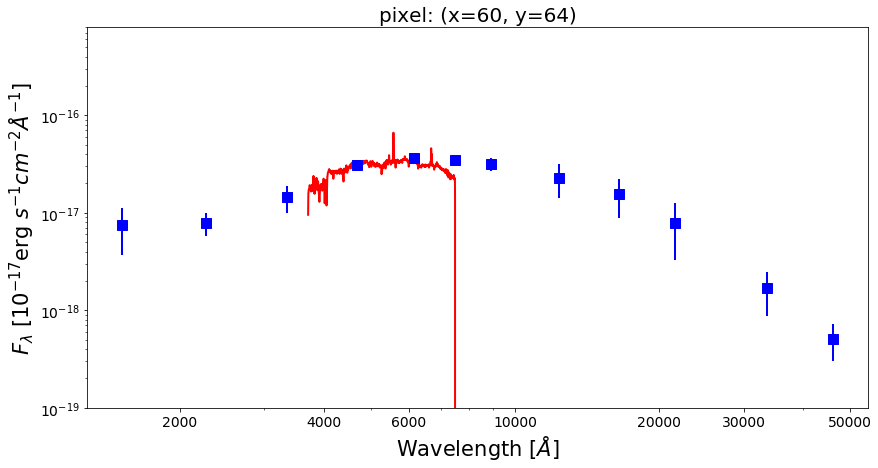

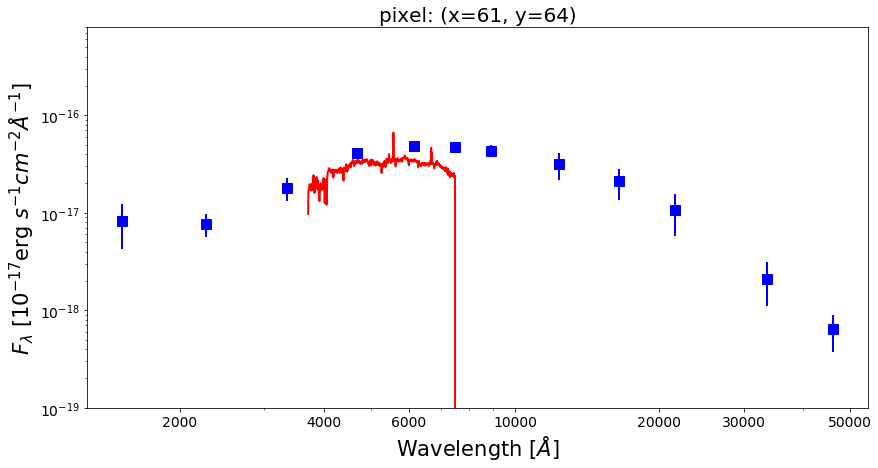

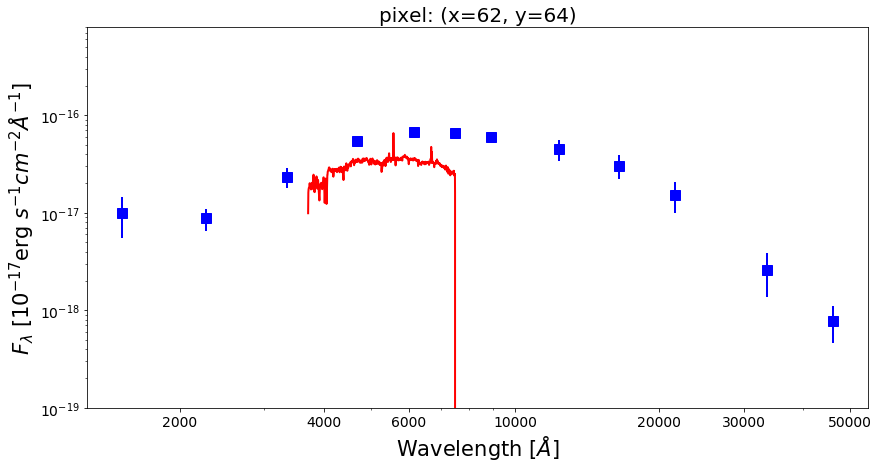

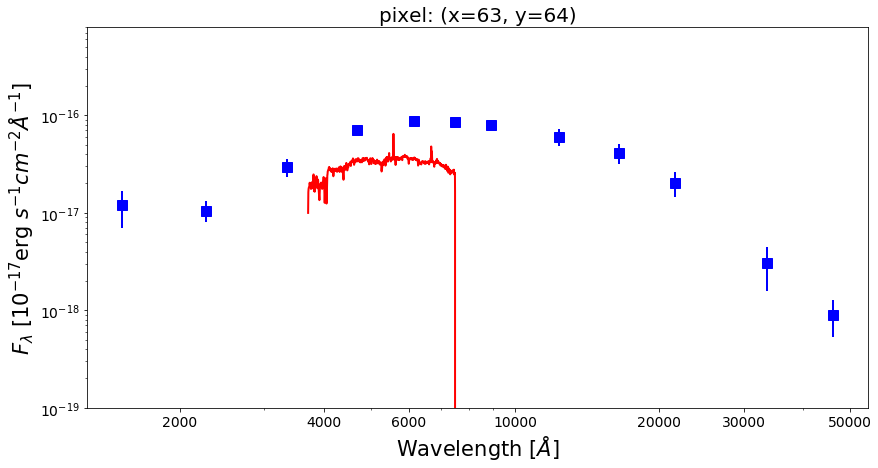

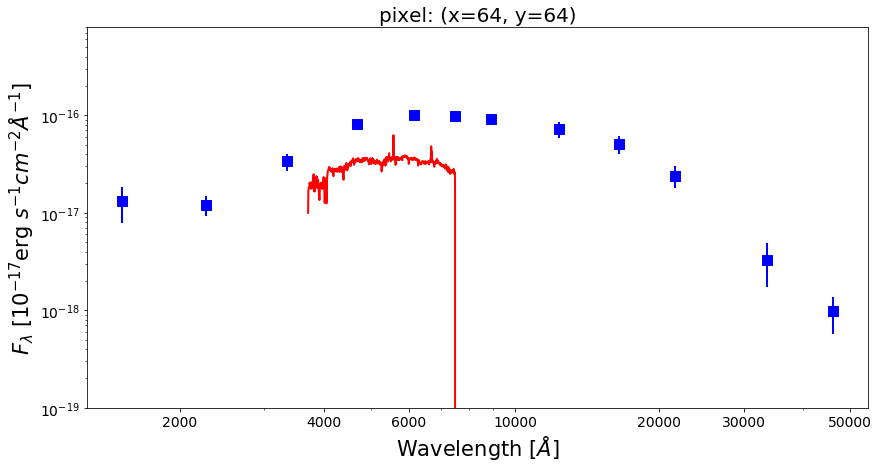

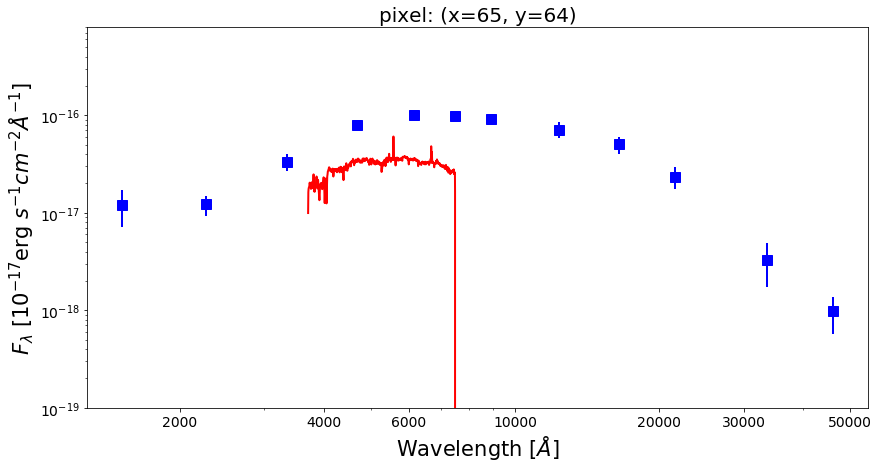

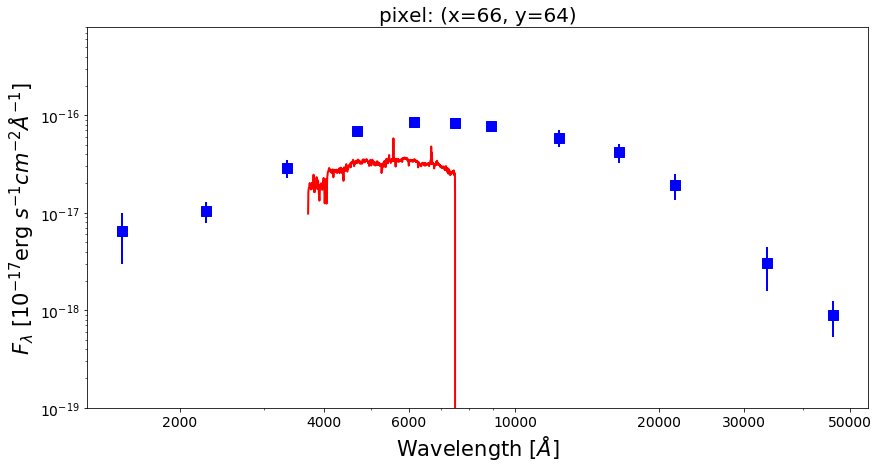

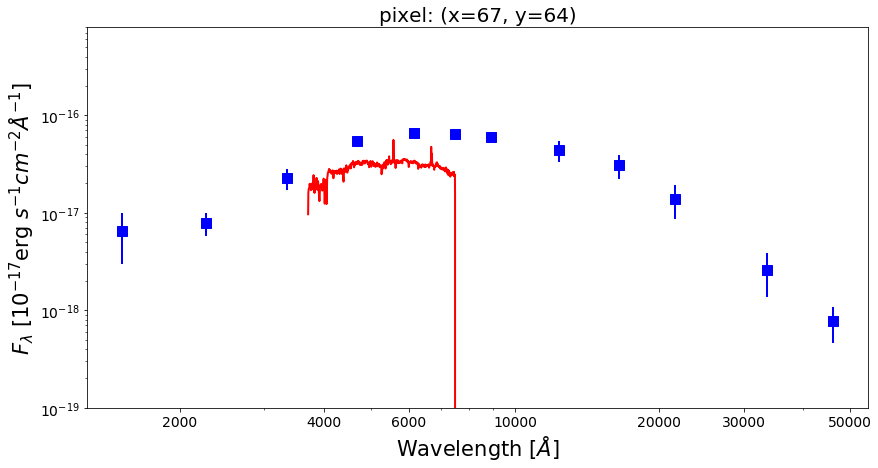

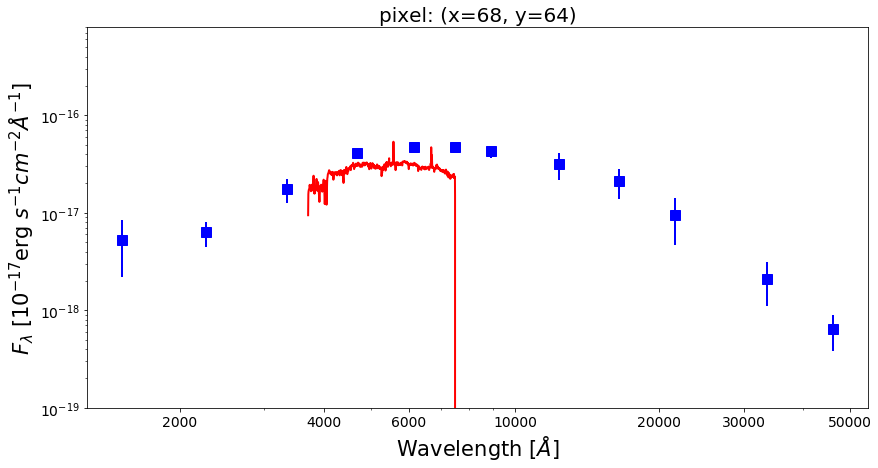

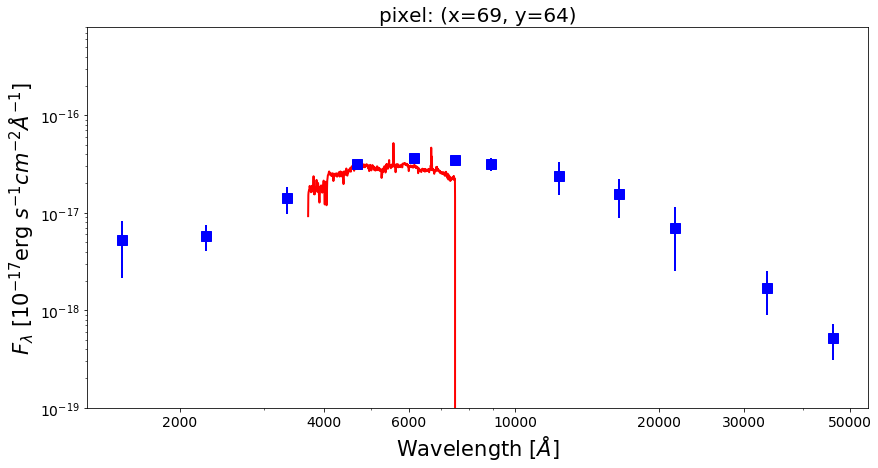

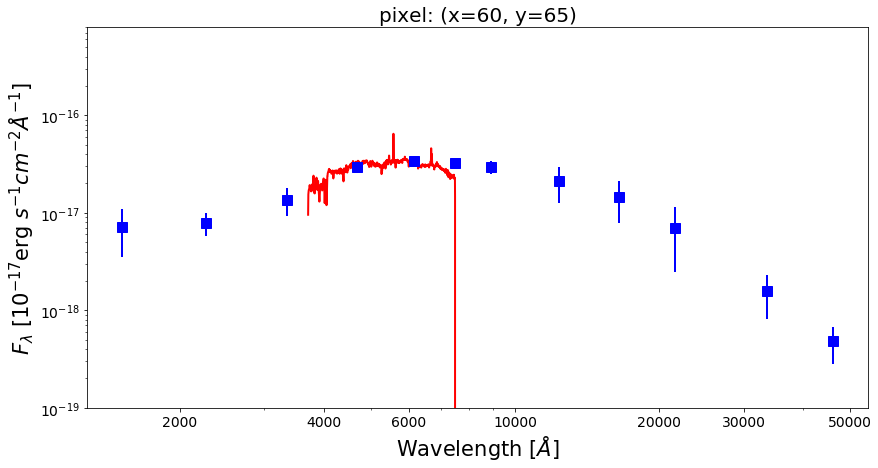

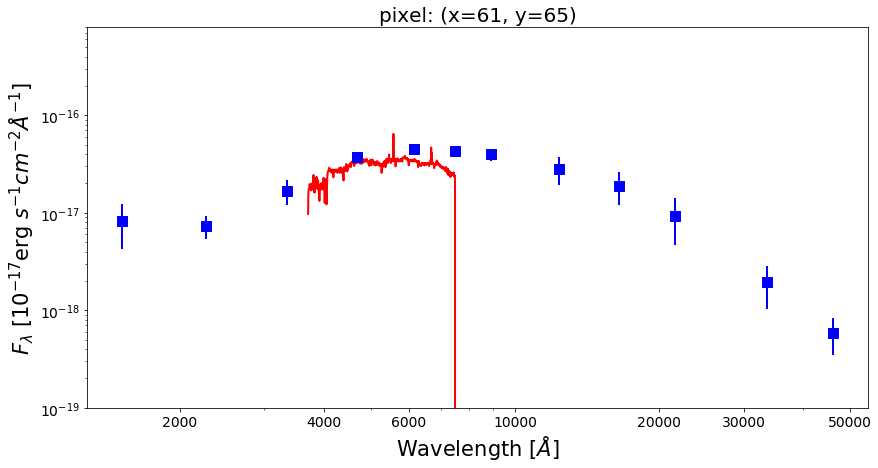

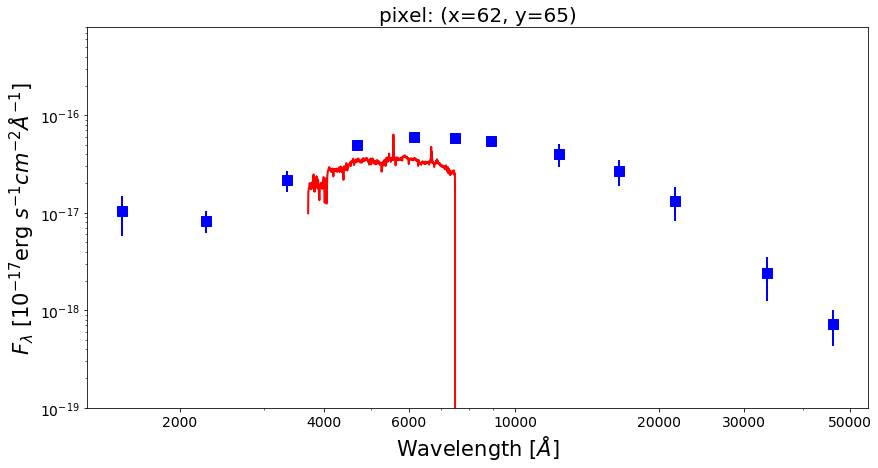

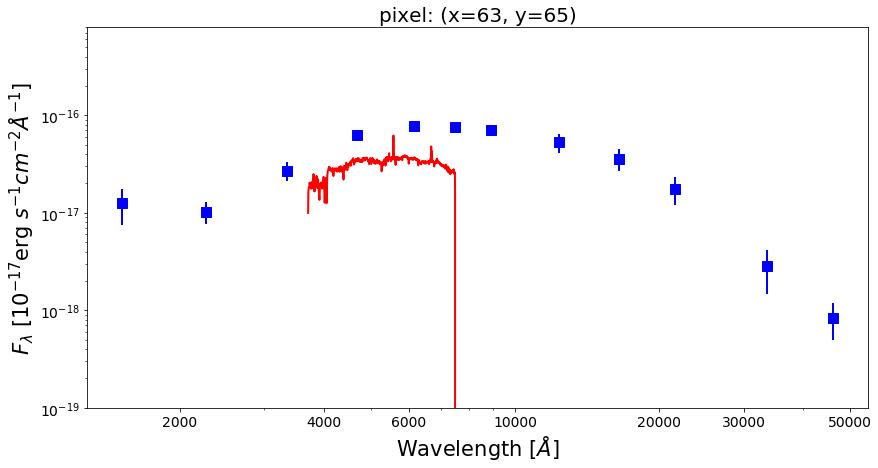

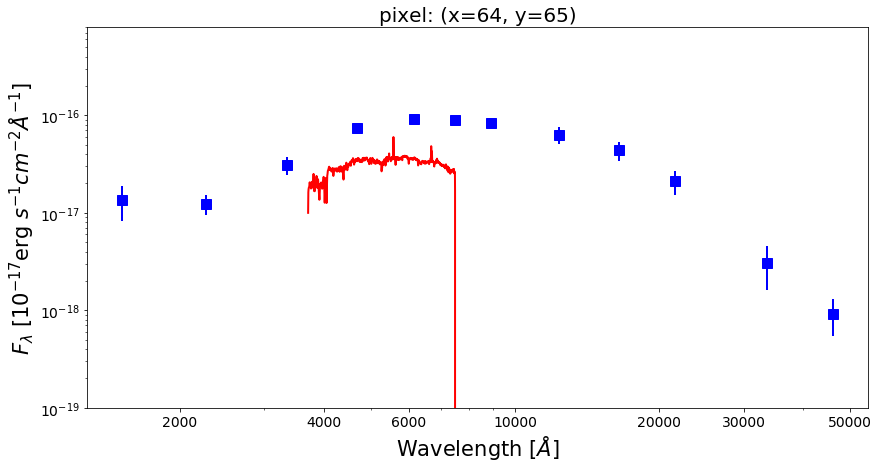

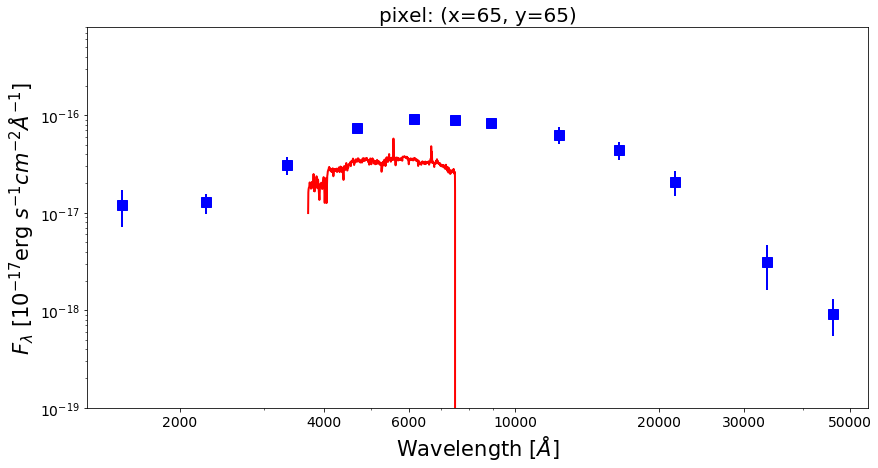

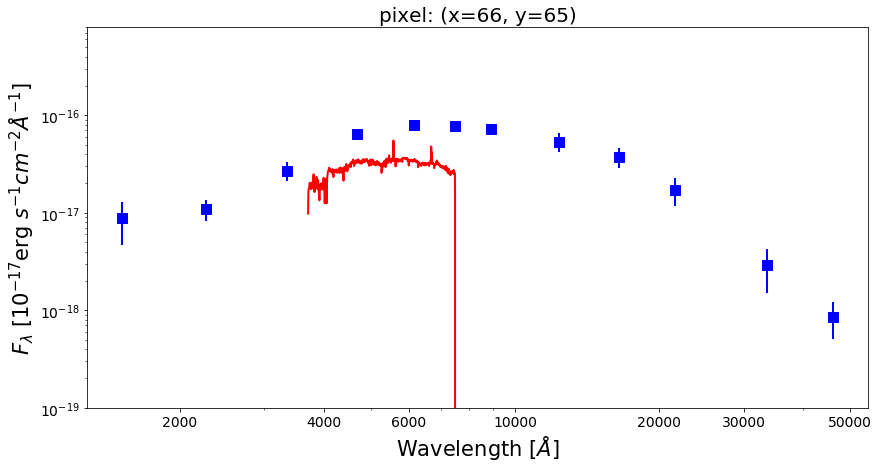

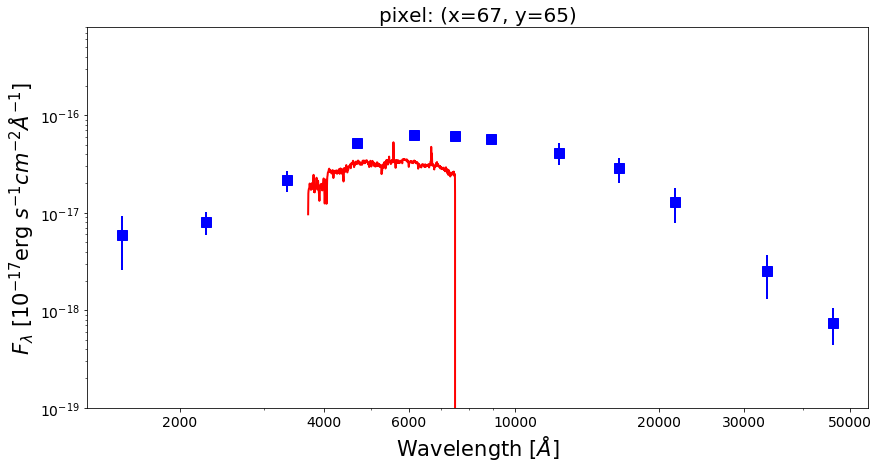

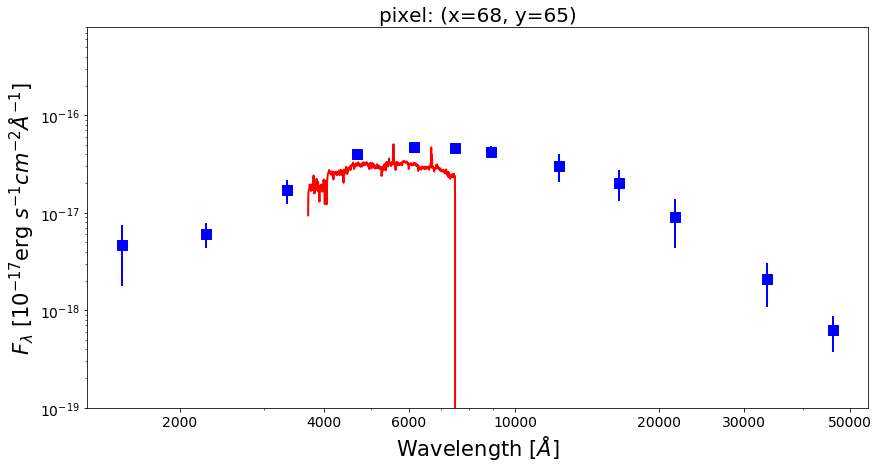

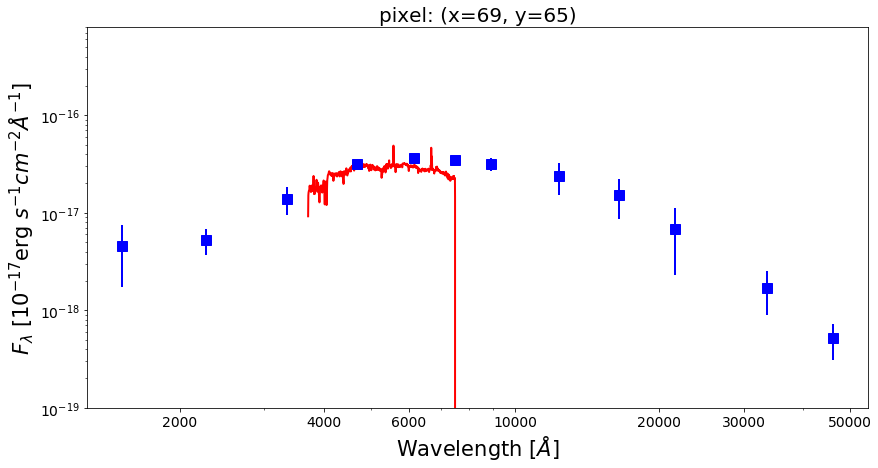

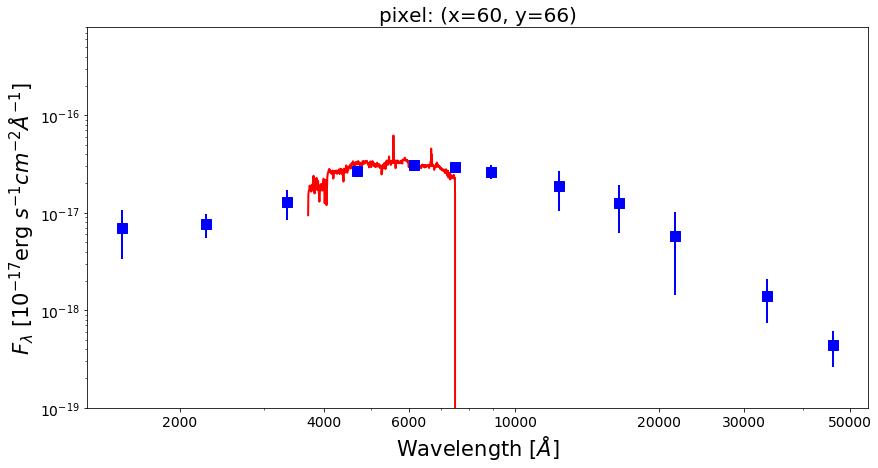

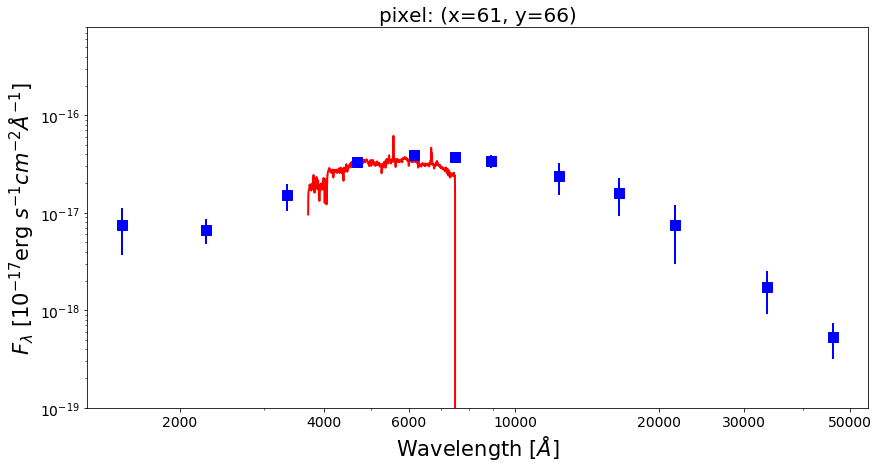

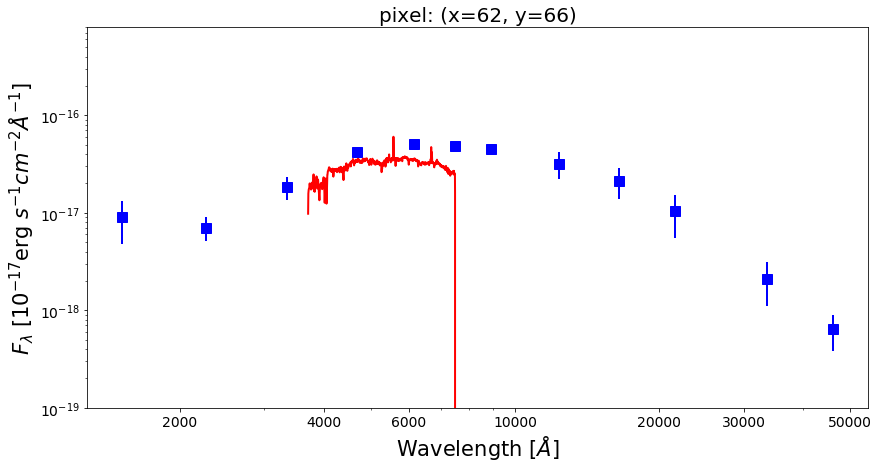

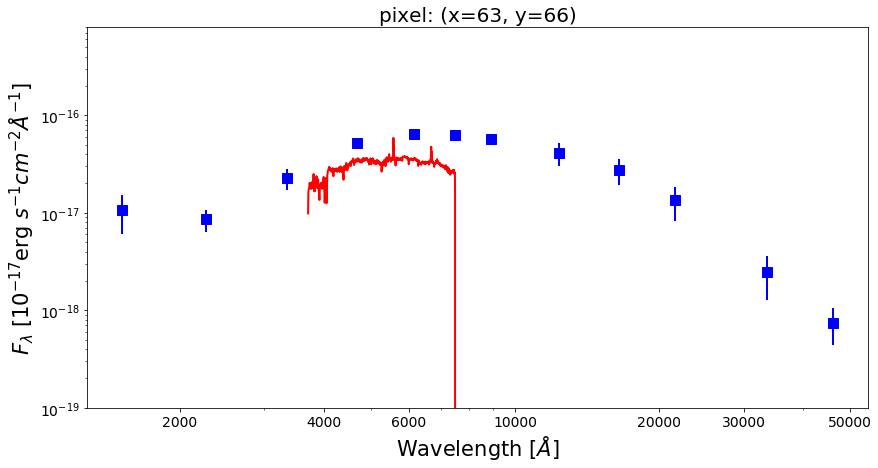

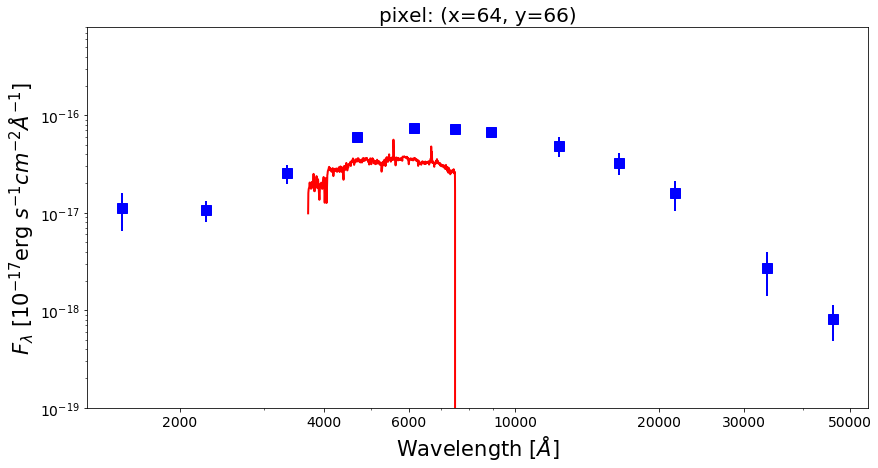

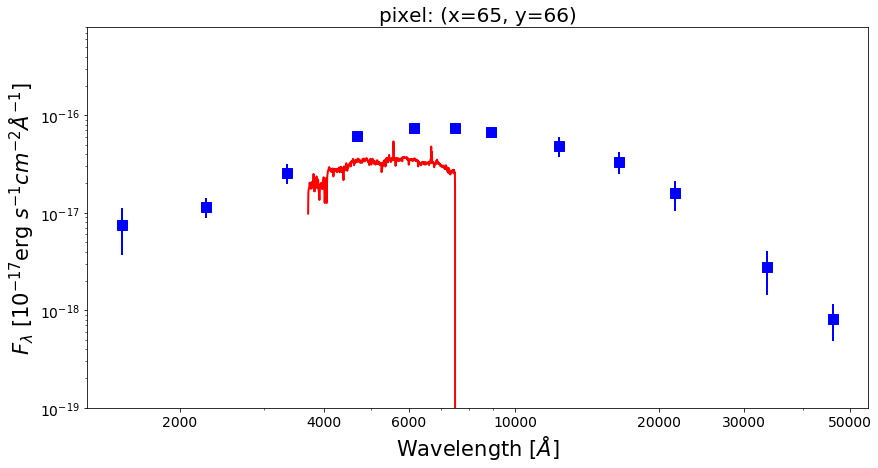

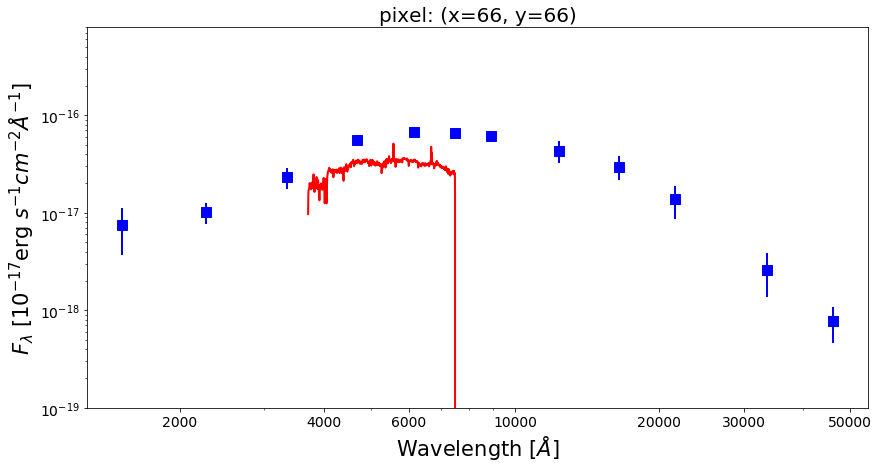

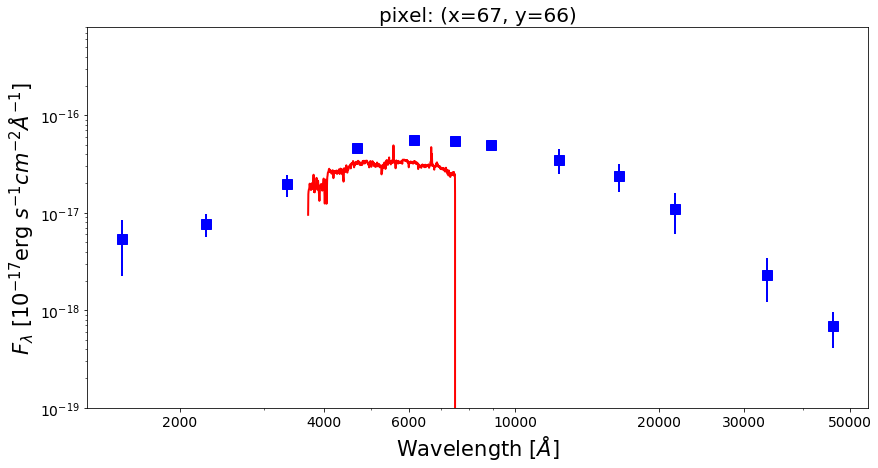

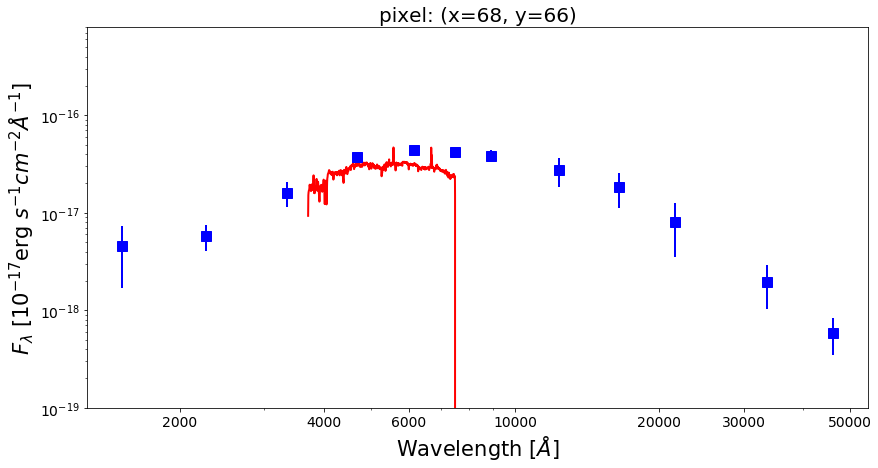

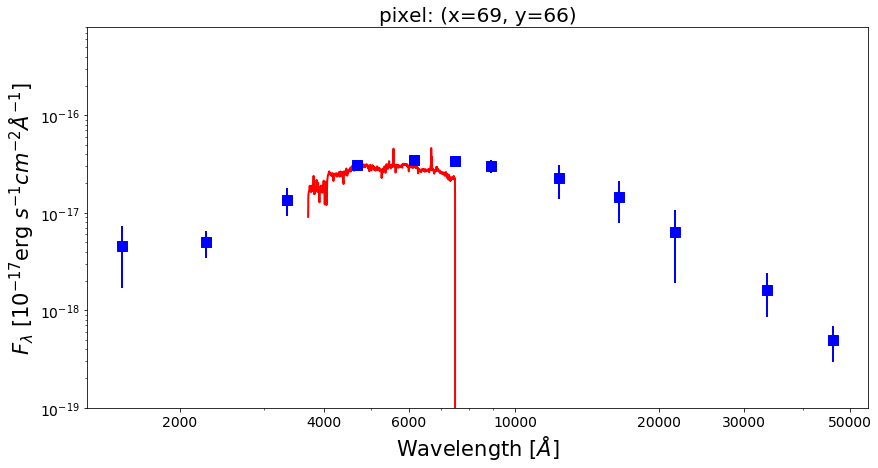

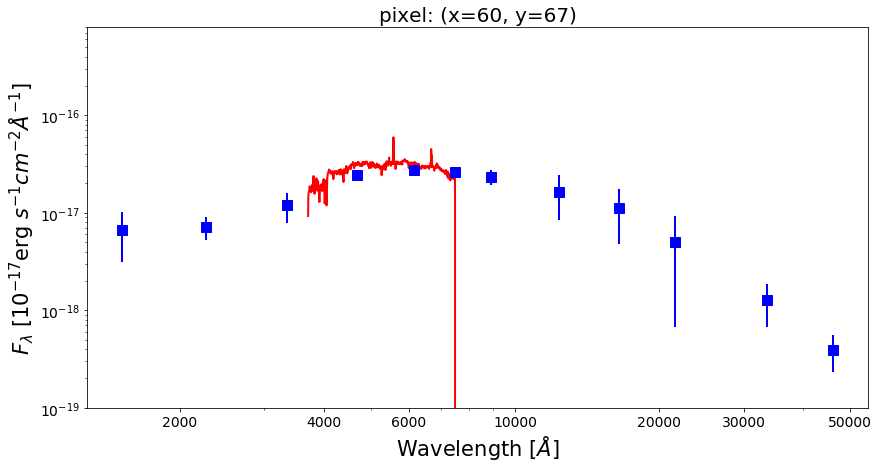

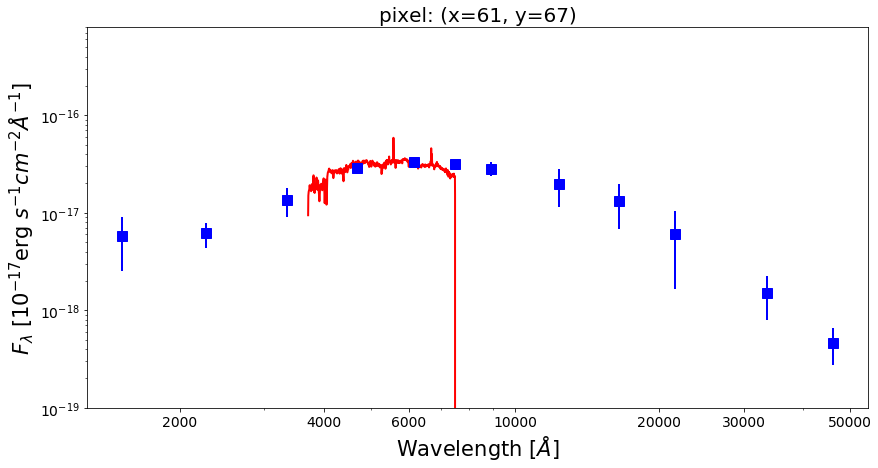

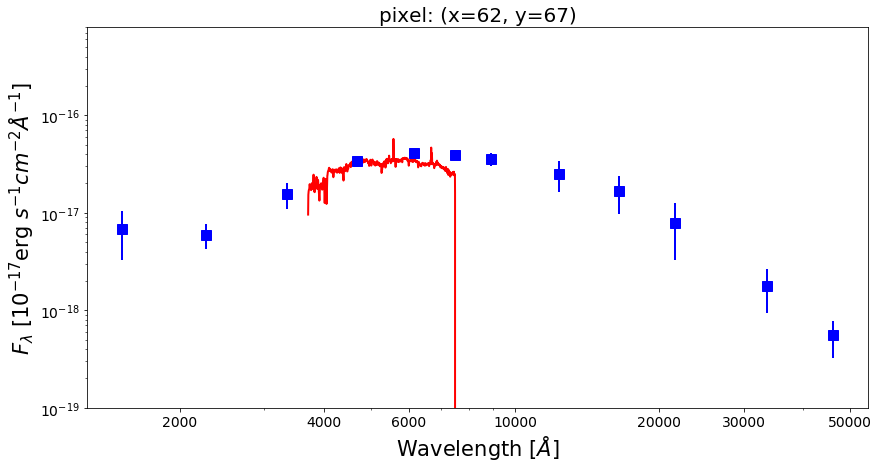

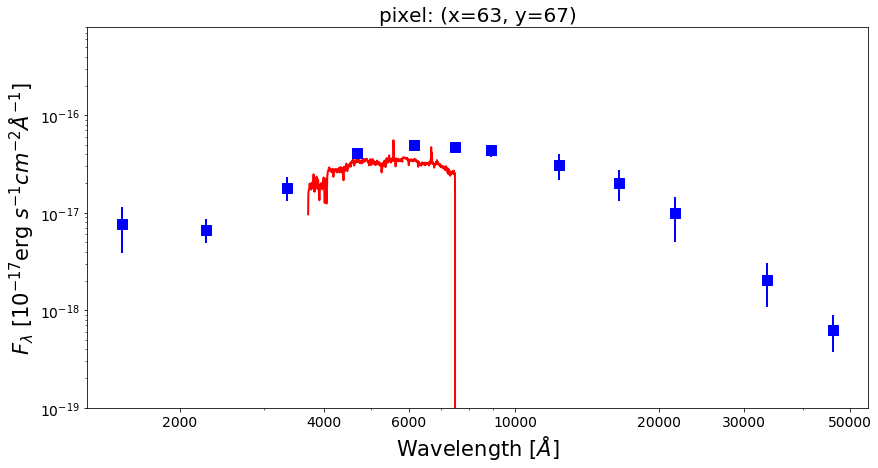

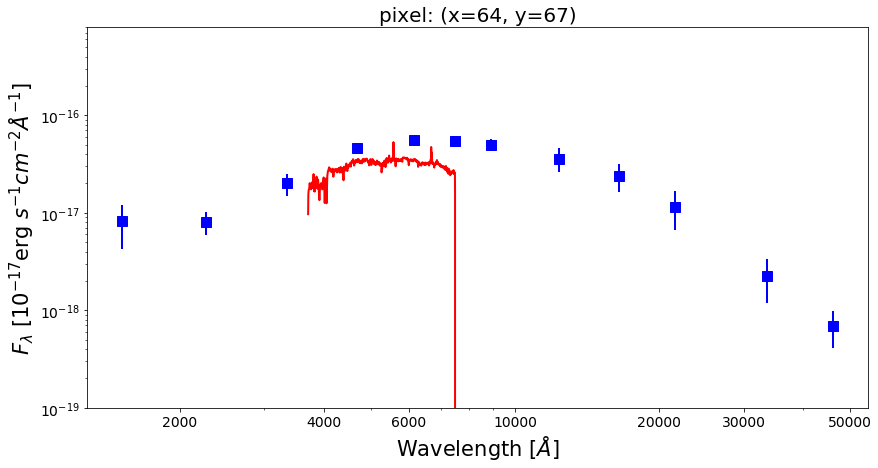

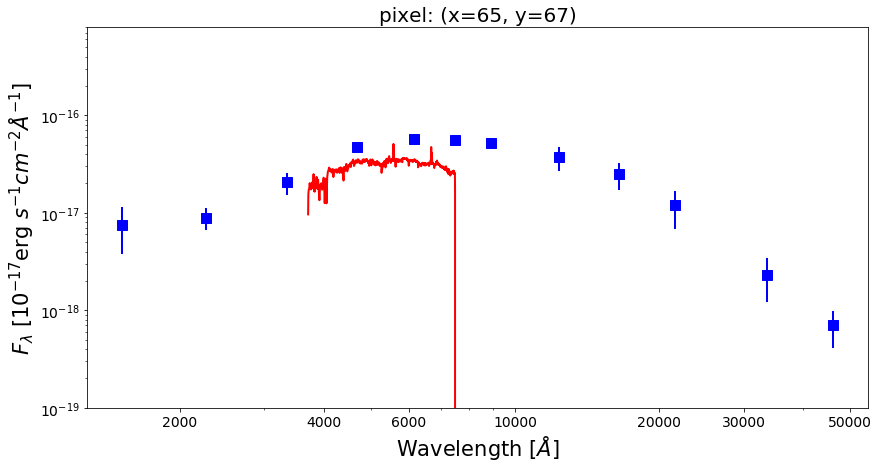

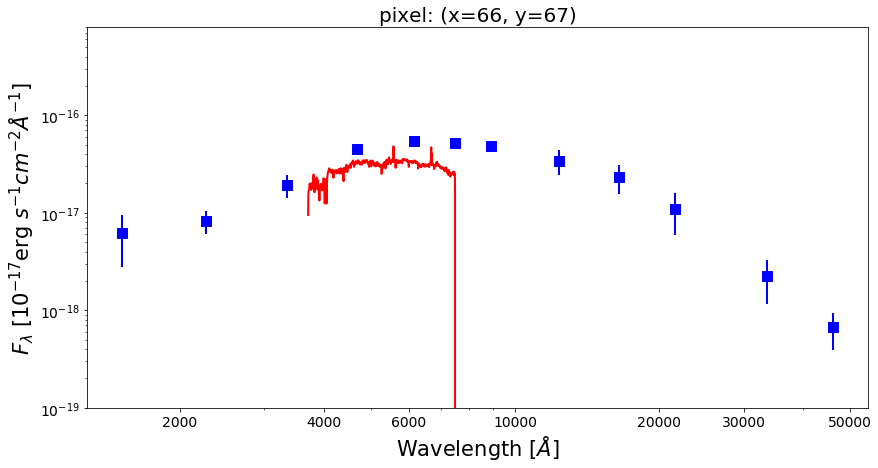

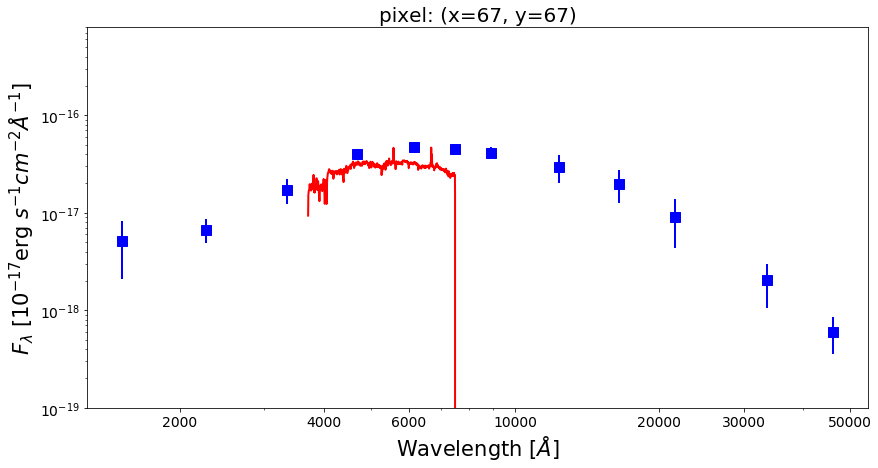

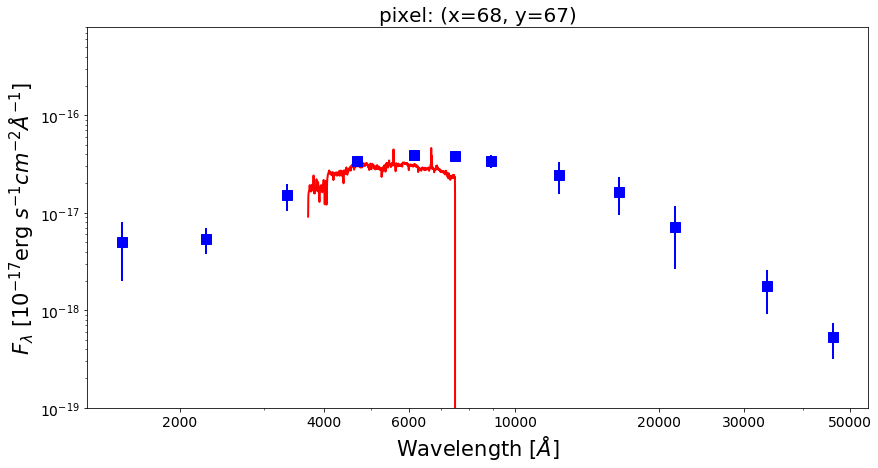

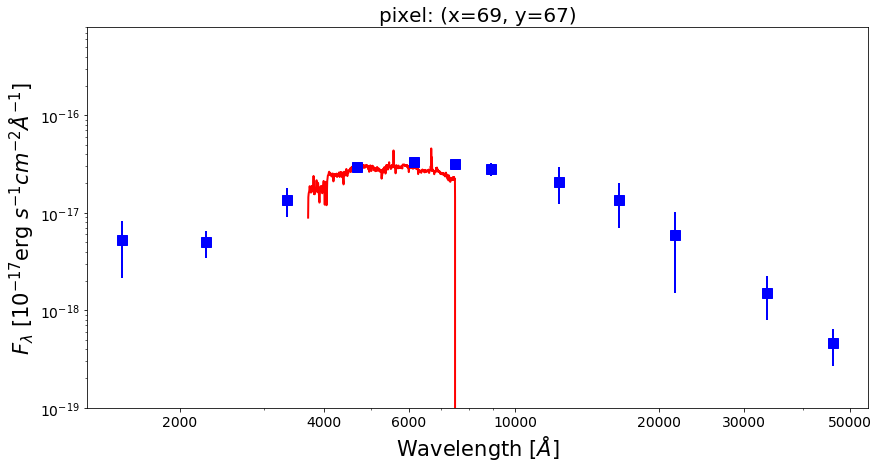

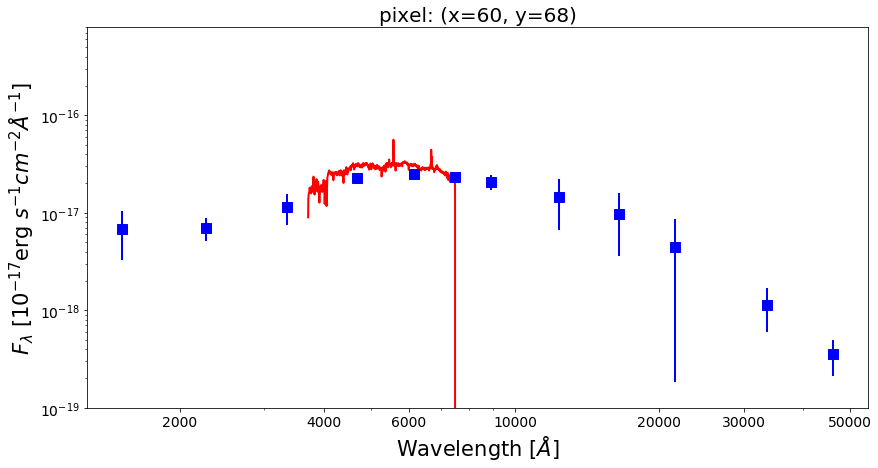

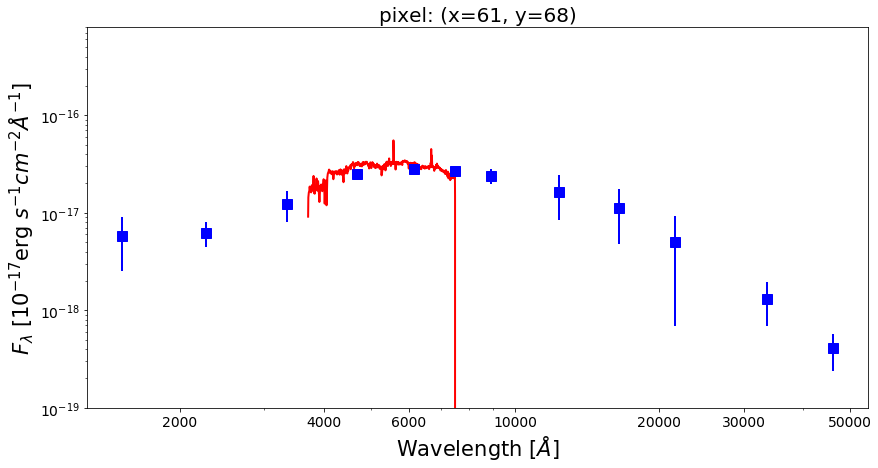

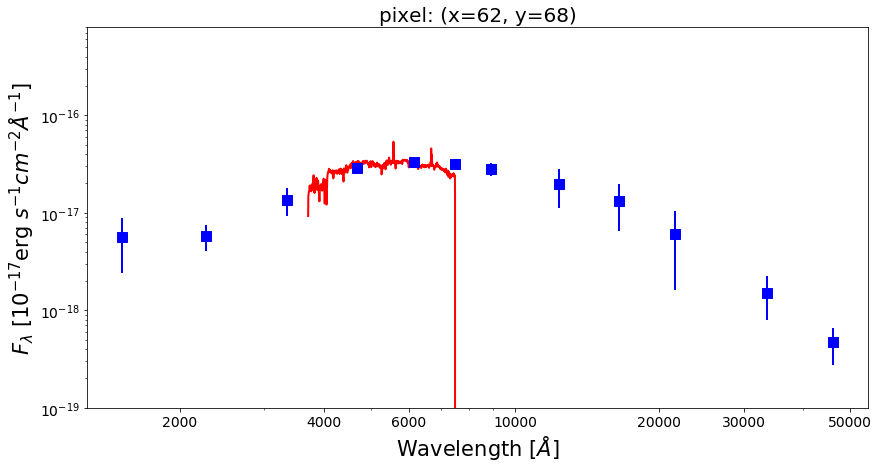

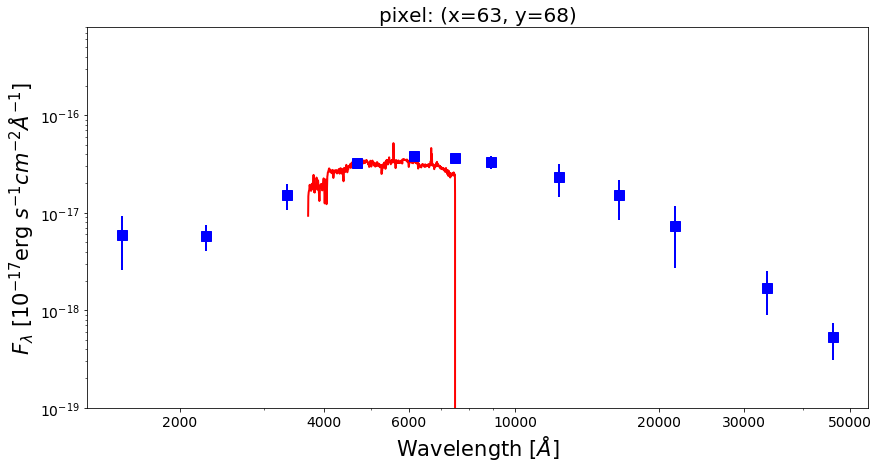

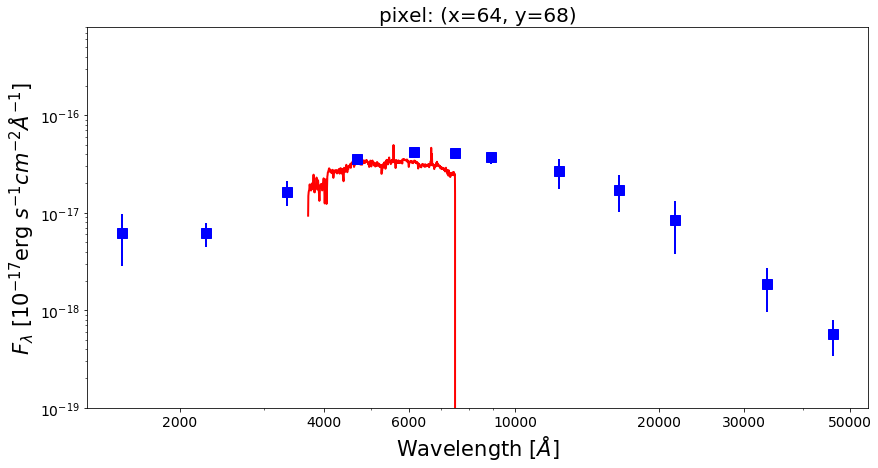

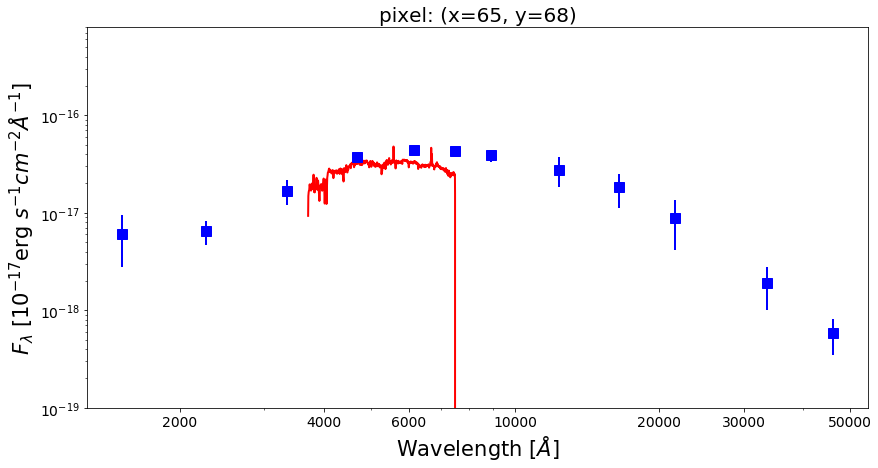

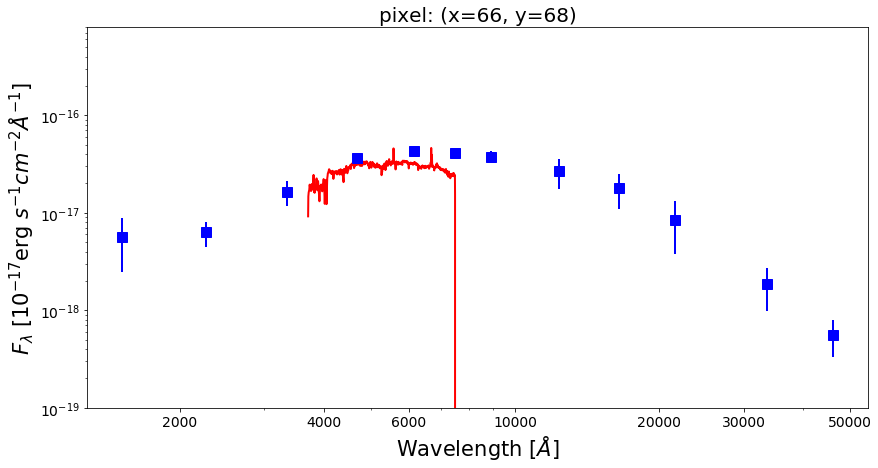

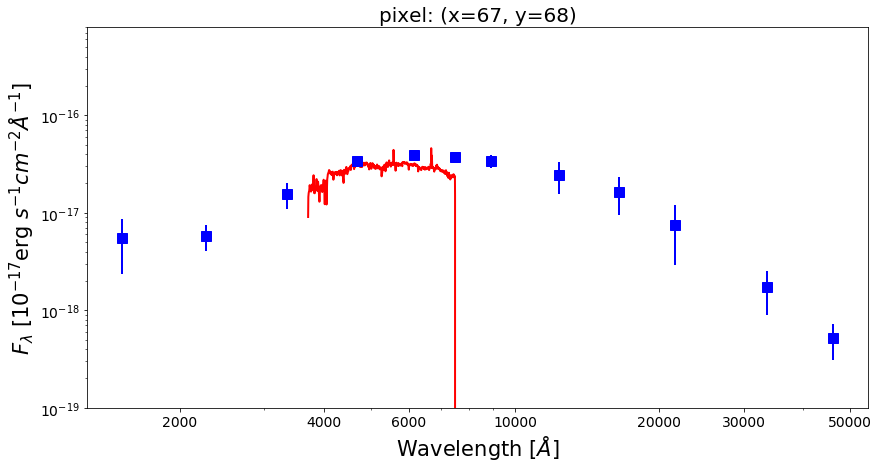

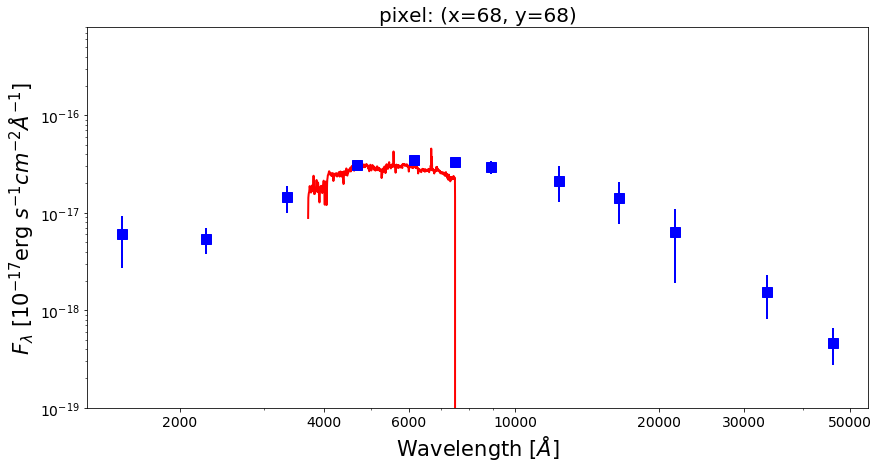

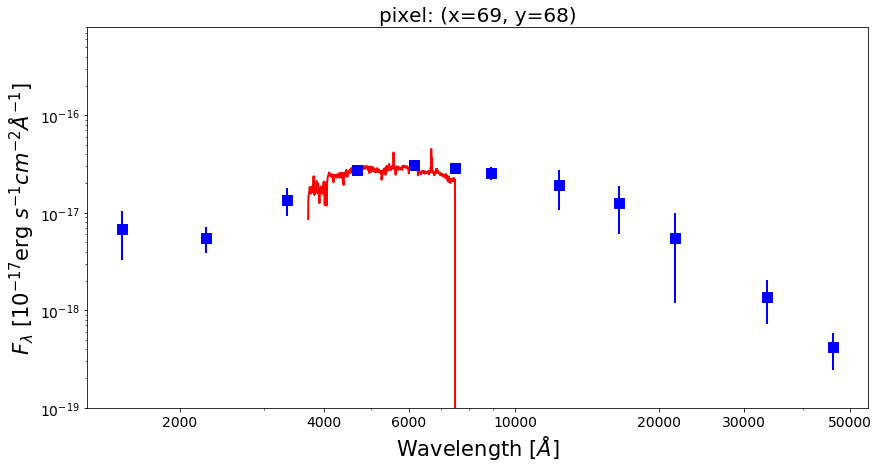

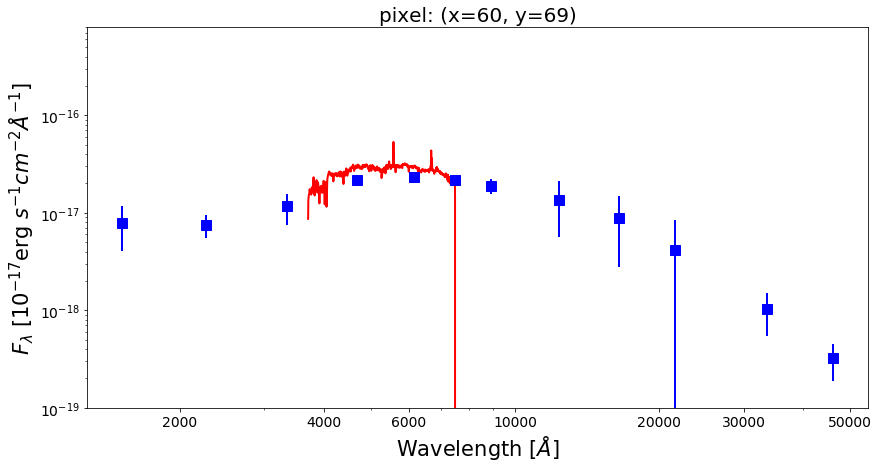

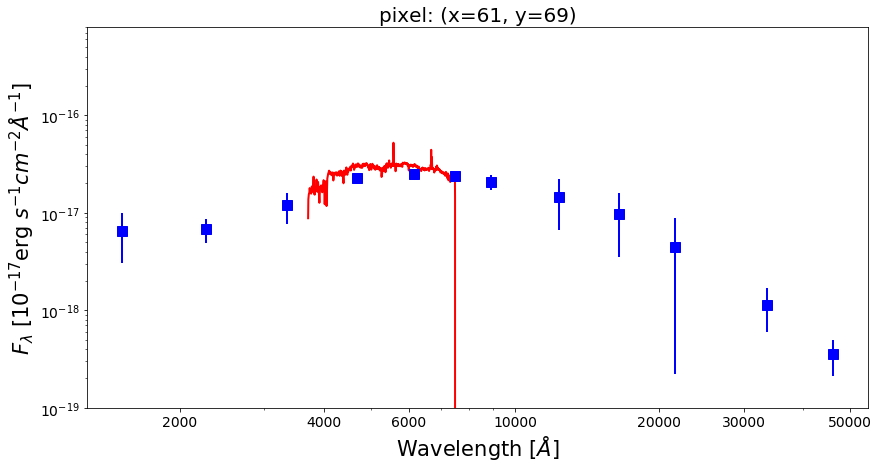

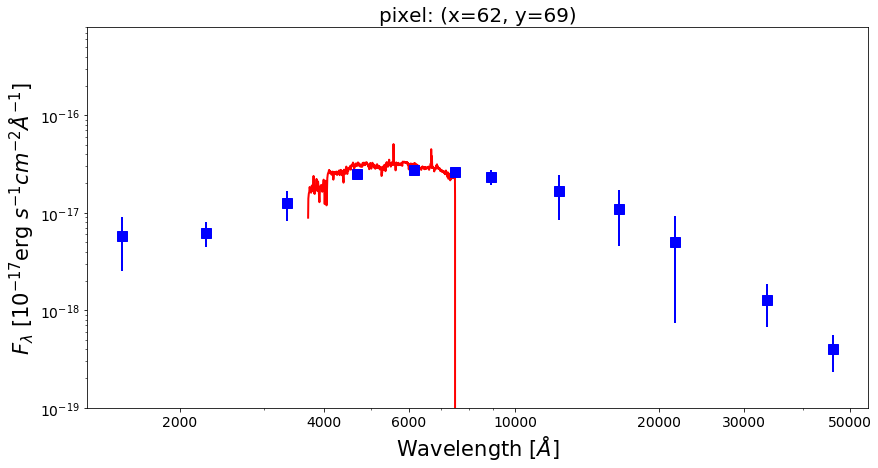

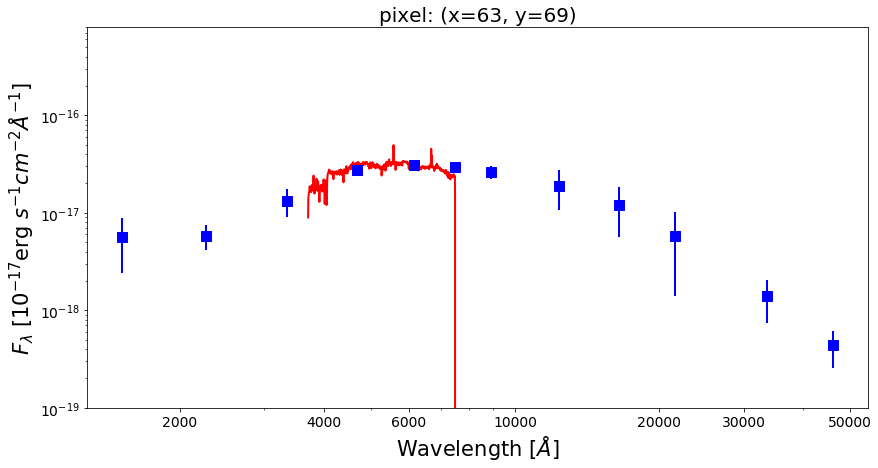

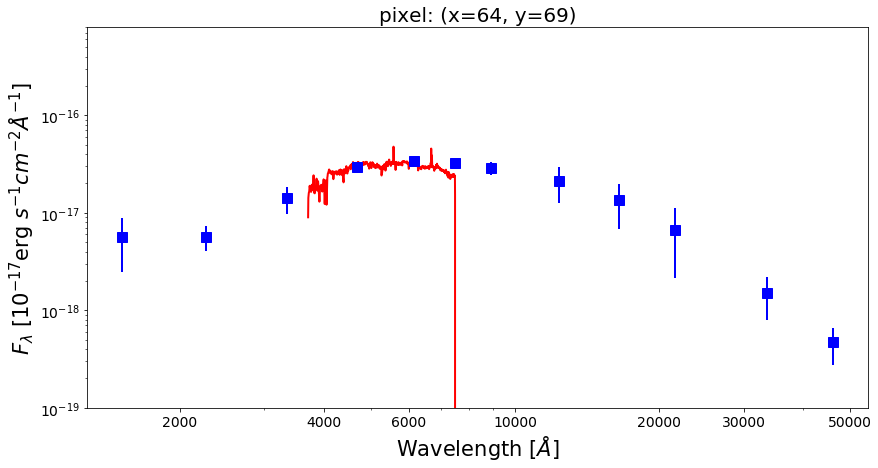

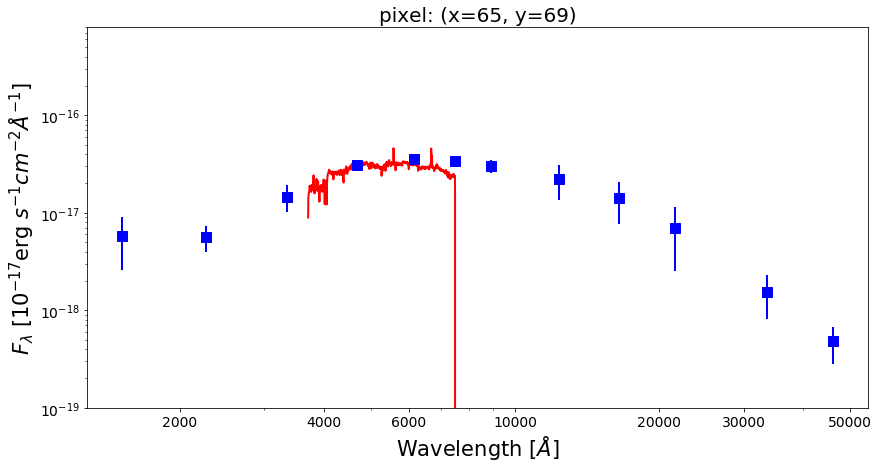

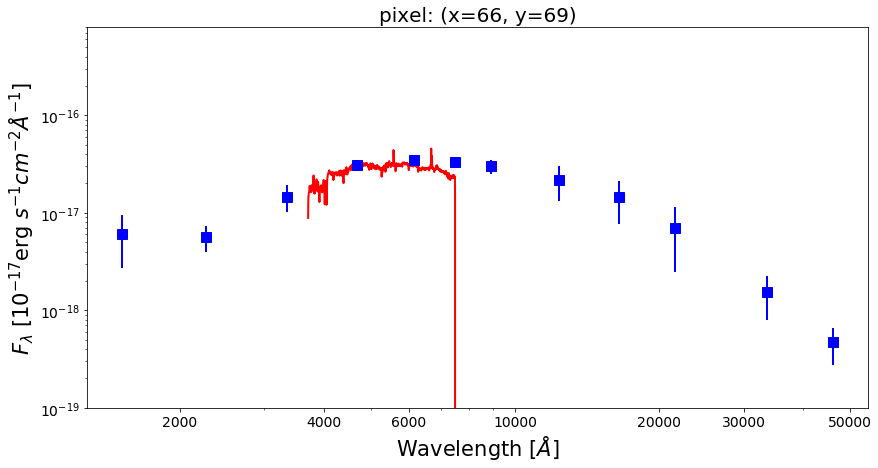

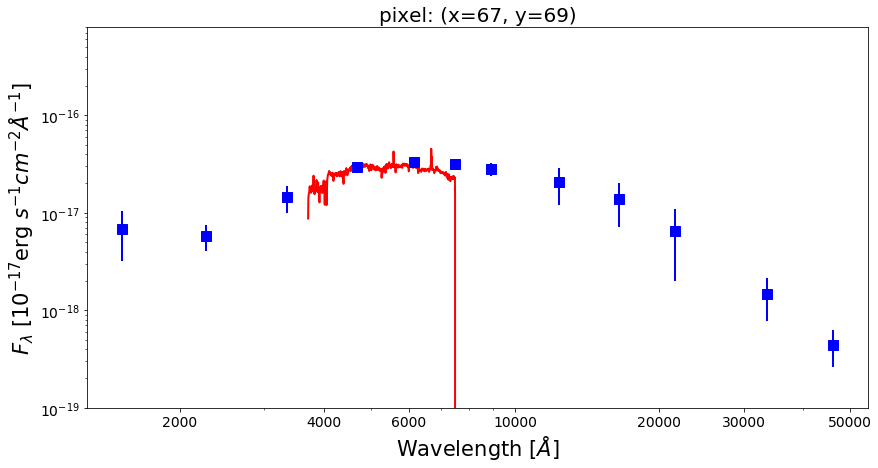

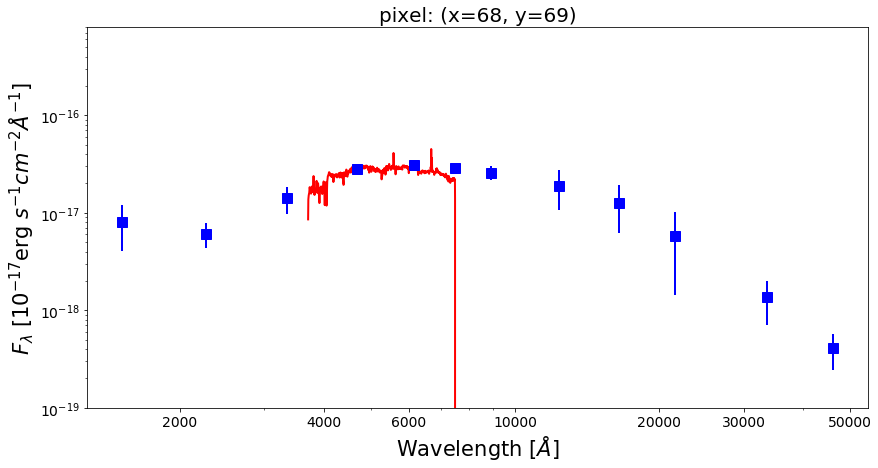

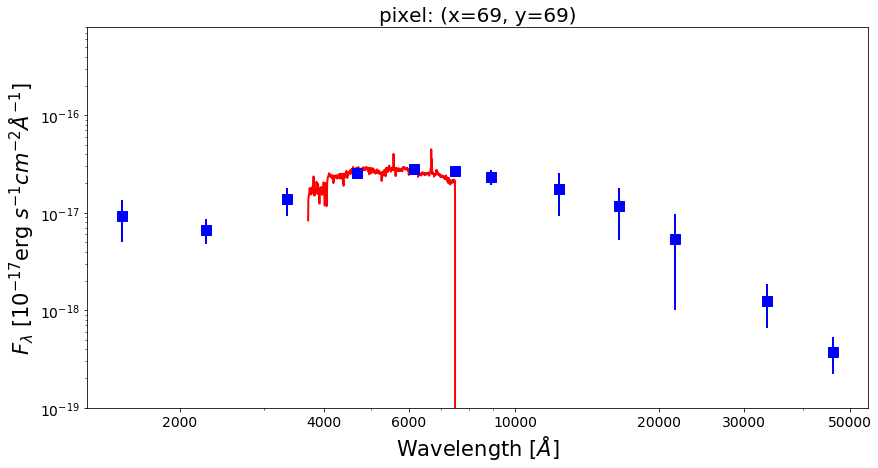

In [14]:
for yy in range(60,70):
    for xx in range(60,70):
        x = int(xx)
        y = int(yy)

        photo_SED = pix_photo_flux[y][x]
        photo_SED_err = pix_photo_flux_err[y][x]
        spec_SED = pix_spec_flux[y][x]
        spec_SED_err = pix_spec_flux_err[y][x]


        ### plotting
        fig1 = plt.figure(figsize=(14,7))
        f1 = plt.subplot()   
        plt.title("pixel: (x=%d, y=%d)" % (x,y), fontsize=20)
        f1.set_yscale('log')
        f1.set_xscale('log')
        plt.setp(f1.get_yticklabels(), fontsize=14)
        plt.setp(f1.get_xticklabels(), fontsize=14)
        plt.xlabel(r'Wavelength $[\AA]$', fontsize=21)
        plt.ylabel(r'$F_{\lambda}$ [$10^{-17}$erg $s^{-1}cm^{-2}\AA^{-1}$]', fontsize=21)
        xticks = [2000,4000,6000,10000,20000,30000,50000]
        plt.xticks(xticks)
        #plt.xlim(3000,10000)
        plt.ylim(1.0e-19,8e-16)
        for axis in [f1.xaxis]:
            axis.set_major_formatter(ScalarFormatter())

        plt.plot(spec_wave, spec_SED, lw=2.0, color='red')
        plt.errorbar(photo_wave, photo_SED, yerr=photo_SED_err, markersize=10,
                                color='blue', fmt='s', lw=2)
        